# Ricky's Notes:

-Sometimes cox gets rid of high variable importance variables decided by the RSF

-Sensitive to random seed sometimes

-Higher num trees usually better

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 
from statsmodels.stats.outliers_influence import variance_inflation_factor   
from lifelines import CoxPHFitter

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# This is from Yaoting's old code setting up the data

In [2]:
clinical_data=pd.read_excel('WithoutMRNEndometrial_TextureFeatures_09182019.xlsx')
other_data=pd.read_excel('1.20.20 DeIdentified_HG_CT_JJM_AS_Clinical Variables_Final.xlsx')

In [237]:
# in this data sets certain rows are excluded so we have to remove them 
#raddata=clinical_data.drop([4, 7, 11, 13, 23, 25, 29, 36, 41, 44, 47, 61, 62, 63, 64, 68, 76, 88, 94, 96, 
 #                         108, 133, 135, 140, 142]).reset_index(drop=True)
#o_data=other_data.drop([4,7, 11, 13, 23, 25, 29, 36, 41, 44, 47, 61, 62, 63, 64, 68, 76, 88, 94, 96, 
 #                         108, 133, 135, 140, 142]).reset_index(drop=True)
raddata=clinical_data.drop([4, 7, 11, 13, 23, 25, 29, 36, 41, 47, 61, 62, 63, 68, 76, 88, 94, 96, 
                         108, 133, 135, 142]).reset_index(drop=True)
o_data=other_data.drop([4,7, 11, 13, 23, 25, 29, 36, 41, 47, 61, 62, 63, 68, 76, 88, 94, 96, 
                         108, 133, 135, 142]).reset_index(drop=True)
o_data = o_data.replace(np.nan, 0)

raddata.columns
coo=pd.DataFrame()
raddata2=raddata.drop(columns=['De identified Study ID'])
print(o_data)

     De-Identified Study ID ExamStatus Tumor Visible          CT_Make  CT_ST  \
0                         1          F             Y   Light Speed 16    5.0   
1                         2          F             Y  Light Speed VCT    5.0   
2                         3          F             Y   Light Speed 16    5.0   
3                         4          F             Y  Discovery CT750    5.0   
4                         6          F             Y  Discovery CT750    5.0   
..                      ...        ...           ...              ...    ...   
130                     153          F             Y  Light Speed VCT    5.0   
131                     154          F             Y   Revolution GSI    5.0   
132                     155          F             Y  Light Speed VCT    5.0   
133                     156          F             Y  Discovery CT750    5.0   
134                     157          F             Y    Revolution HD    5.0   

     CT_kVp  CT_mA  CT_Pitch  Age at Dx

In [238]:
#preprocessed VIF filtered features
#cols = ['LBP86', 'LBP90', 'LBP92', 'LBP94', 'LBP99', 'LBP101', 'LBP102',
#       'LBP103', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116', 'LBP118',
#       'LBP119', 'LBP120', 'FD27', 'FD48', 'FD51', 'FD54', 'ACM1_12']

#yaoting's preprocessed data
cols = ['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
      'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12']
raddata2 = raddata2.loc[:, cols]
raddata2

,LBP94,LBP101,LBP106,LBP107,LBP108,LBP112,LBP116,LBP118,LBP119,LBP120,FD27,FD51,FD54,ACM1_12
0,0.008640,0.013356,0.004859,0.004859,0.004132,0.000000,0.010616,0.007653,0.002066,0.000000,9.000000,0.079923,0.068974,-0.072218
1,0.007668,0.048193,0.000000,0.004474,0.002237,0.002237,0.022017,0.025663,0.002237,0.002268,3.333333,0.128958,0.112149,-0.128768
2,0.021092,0.012521,0.004832,0.004832,0.002381,0.002381,0.010747,0.013208,0.000456,0.000000,15.250000,0.056418,0.044223,-0.044774
3,0.016198,0.010369,0.000418,0.000418,0.002021,0.001185,0.009453,0.017735,0.000000,0.001094,15.750000,0.141440,0.121297,-0.076017
4,0.009955,0.005240,0.002404,0.002404,0.000000,0.000000,0.014629,0.011696,0.004484,0.000000,8.000000,0.157050,0.145854,-0.071011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.022039,0.010716,0.003116,0.003159,0.003084,0.002702,0.008869,0.014814,0.000392,0.000713,24.500000,0.087100,0.067616,-0.051001
131,0.012268,0.011711,0.001980,0.002713,0.001017,0.000758,0.006853,0.014726,0.001896,0.000630,25.888889,0.055196,0.037529,-0.155972
132,0.015814,0.010354,0.001611,0.003510,0.000773,0.000773,0.008804,0.009672,0.002337,0.000396,31.714286,0.100156,0.067450,-0.041698
133,0.019432,0.016423,0.002315,0.002550,0.001315,0.000583,0.009172,0.014753,0.000963,0.000259,59.888889,0.112976,0.065836,-0.032100


## coo =  clinical outcomes? not sure, but just following old naming convention

In [239]:
coo['age']=o_data['Age at Dx']
coo['adjuvalent']=o_data['Adjuvant treatment (y/n)']
coo['Chemo']=o_data['Chemo (y/n)']
coo['Diabetes']=o_data['Diabetes (y/n)']
coo['Node Status']=o_data['Node Status (+/-)']
coo['RT'] = o_data['RT (y/n)']
coo

,age,adjuvalent,Chemo,Diabetes,Node Status,RT
0,69,1.0,1.0,0.0,0.0,1.0
1,71,1.0,1.0,0.0,0.0,1.0
2,55,1.0,1.0,0.0,0.0,1.0
3,61,1.0,1.0,0.0,0.0,1.0
4,63,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
130,64,1.0,1.0,0.0,0.0,1.0
131,73,1.0,0.0,1.0,0.0,1.0
132,70,1.0,0.0,0.0,0.0,1.0
133,68,1.0,1.0,1.0,0.0,1.0


In [240]:
# dummyfying variables
#here we use get_dummies to create dummy variables 
test=o_data.loc[:,['Race', 'BMI-Category', 'Histology']]
test2=pd.get_dummies(test['Race'], prefix='race')

test3=pd.get_dummies(test['BMI-Category'], prefix ='BMI')
test4=pd.get_dummies(test['Histology'], prefix='Hist')
new_test=pd.concat([test2, test3, test4], axis=1)
new_test

,race_0.0,race_1.0,race_2.0,race_3.0,race_4.0,BMI_0.0,BMI_1.0,BMI_2.0,Hist_0,Hist_1,Hist_2,Hist_3,Hist_4
0,0,1,0,0,0,0,1,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,0,0,0,0,0,1,0,0,1,0,0,0
131,0,0,1,0,0,1,0,0,0,0,1,0,0
132,0,0,1,0,0,1,0,0,1,0,0,0,0
133,1,0,0,0,0,0,1,0,0,0,1,0,0


In [241]:
outcomes =pd.DataFrame()
outcomes['time column']=o_data['Time to Recurrence (months)']
outcomes['event column']=o_data['Recurrence (y/n)']

## this is where the code diverges from original notebook, saving 3 feature sets (clinical data, radiomics, raciomics + clinical data), then performing feature selection and RSF on each differently than the original code

In [339]:
clin_var_only = pd.concat([coo, new_test], axis=1)

# adding the BMI>30 and BMI>40 categories
bmi_sum = clin_var_only["BMI_1.0"] + clin_var_only["BMI_2.0"]
preop_vars = clin_var_only[['age', 'race_1.0', 'Diabetes', 'Hist_0']].copy()
preop_vars['BMI>30'] = bmi_sum

#post-op model
postop_vars = preop_vars
postop_vars['Node Status'] = clin_var_only['Node Status']

#complete model
complete_vars = postop_vars
complete_vars['RT'] = clin_var_only['RT']
complete_vars['Chemo'] = clin_var_only['Chemo']

#creating different variable combinations
preop_vars_only = pd.concat([preop_vars, outcomes], axis=1)
postop_vars_only = pd.concat([postop_vars, outcomes], axis=1)
complete_vars_only = pd.concat([complete_vars, outcomes], axis=1)

radiomics_only = pd.concat([raddata2, outcomes], axis=1)
preop_and_radiomics = pd.concat([preop_vars, raddata2, outcomes], axis=1)
postop_and_radiomics = pd.concat([postop_vars, raddata2, outcomes], axis=1)
complete_and_radiomics = pd.concat([complete_vars, raddata2, outcomes], axis=1)
unfiltered_radiomics = pd.concat([complete_vars, raddata, outcomes], axis=1)


In [340]:
#combining with and without radiomics and saving as csv
preop_vars_only.to_csv('preop_vars_only.csv', index=False)
postop_vars_only.to_csv('postop_vars_only.csv', index=False)
complete_vars_only.to_csv('complete_vars_only.csv', index=False)
radiomics_only.to_csv('radiomics_only.csv', index=False)
preop_and_radiomics.to_csv('preop_and_radiomics.csv', index=False)
postop_and_radiomics.to_csv('postop_and_radiomics.csv', index=False)
complete_and_radiomics.to_csv('complete_and_radiomics.csv', index=False)
unfiltered_radiomics.to_csv('unfiltered_radiomics.csv', index=False)

## functions from the liver mets code

In [334]:
def cox_feature_select(data):    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()

    #computing max numer of samples 
    num_samples = data.shape[0]
    max_num_features = math.ceil(num_samples/10)
    print("max =" + str(max_num_features))
    cph = CoxPHFitter()
    cph.fit(data, duration_col = time_column, event_col=event_column)  

    #getting coefficients
    hr = abs(cph.params_)
    print(hr)
    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    print(filtered_hr)
    index_names = filtered_hr.index

    col_names = []
    for x in range(1,len(index_names)):
        col_names.append(index_names[x])

    col_names.append(time_column)
    col_names.append(event_column)

    filtered_data = data.filter(items=col_names, axis=1)
    print(index_names)
    return filtered_data

 

def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    #legacy code, used to be data1=data.drop(columns=['filename'])
    data1=data
    time_column='time column'
    event_column='event column'
    
    data1 = data1.drop(columns=[time_column, event_column])
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    data2 = calculate_vif_(data1, 100)
    data2[['time column']] = data[['time column']]
    data2[['event column']] = data[['event column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    #feature selecting by taking high odds variables from Cox regression if not enough samples
    data_temp = cox_feature_select(data2)
    data2 = data_temp
    
    # saving a copy to not repeat feature selection again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName, index=False)

    return data2

In [324]:
# this can definitely be modularized later

# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(100, 200, 300, 400)
    max_depth=(1, 2, 5, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 5
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.80, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 5
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    #variable importances
    var_imp_dict = {}
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1
        
        var_imps = xst.variable_importance_table
        var_list = var_imps['feature'].to_list()
        
        if 'imps' in locals():
            garbage=1
            #importance dictionary already made
        else:
            imps = {key:[] for key in var_list}
            pcts = {key:[] for key in var_list}
            
        for var_name in var_list:
            imps[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['importance'].iloc[0])
            pcts[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['pct_importance'].iloc[0])
            
    var_imps_list = []
    for var_name in var_list:
        imp_avg = mean(imps[var_name])
        imp_std = statistics.stdev(imps[var_name])
        pct_avg = mean(pcts[var_name])
        pct_std = statistics.stdev(pcts[var_name])

        var_imps_list.append([var_name, imp_avg, imp_std, pct_avg, pct_std])   
        
    #just printing for now, can use as return value later if you want
    var_imps_df = pd.DataFrame(var_imps_list, columns = ['Variable', 'Imp Avg','Imp Std', 'Pct Avg', 'Pct Std'])
    print(var_imps_df)
    
    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


# main script starts here

In [341]:
preop_vars_only = 'preop_vars_only.csv'
postop_vars_only ='postop_vars_only.csv'
complete_vars_only = 'complete_vars_only.csv'
radiomics_only = 'radiomics_only.csv'
preop_and_radiomics = 'preop_and_radiomics.csv'
postop_and_radiomics = 'postop_and_radiomics.csv'
complete_and_radiomics = 'complete_and_radiomics.csv'
unfiltered_radiomics = 'unfiltered_radiomics.csv'
#creating different combinations of data

data_list = list()
data_list.extend((preop_vars_only, postop_vars_only, complete_vars_only, radiomics_only,
                 preop_and_radiomics, postop_and_radiomics, complete_and_radiomics, unfiltered_radiomics))


Processing: preop_vars_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: preop_vars_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


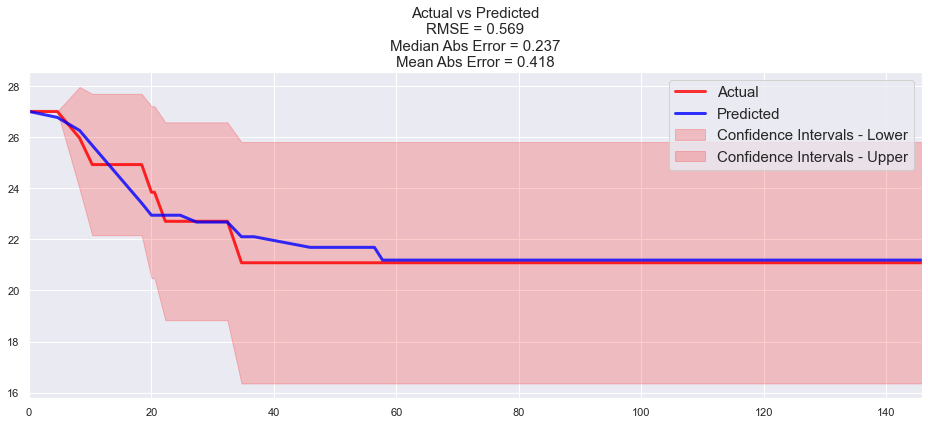

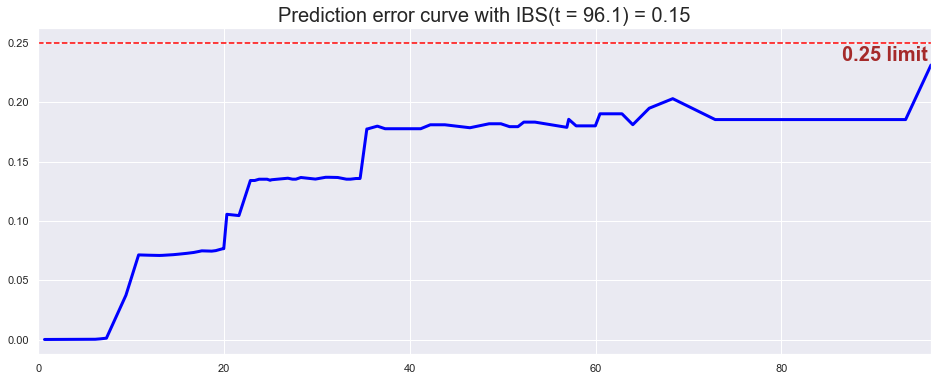

C-index: 0.62
IBS: 0.15

 2 of kfold 5


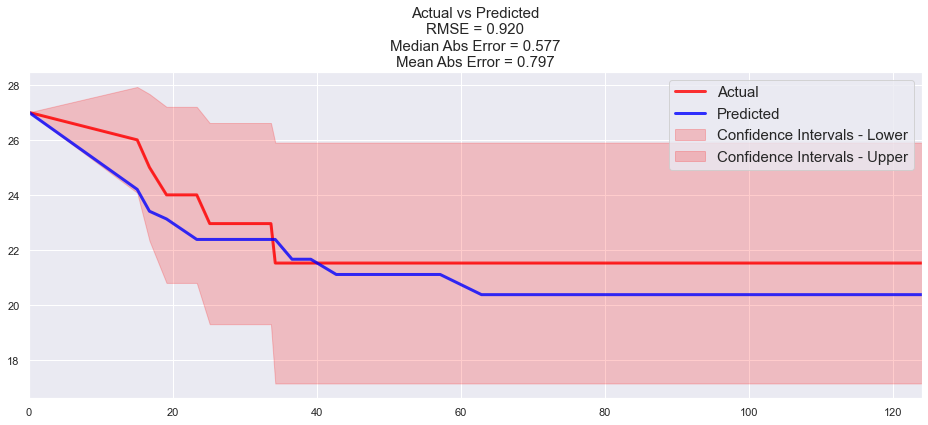

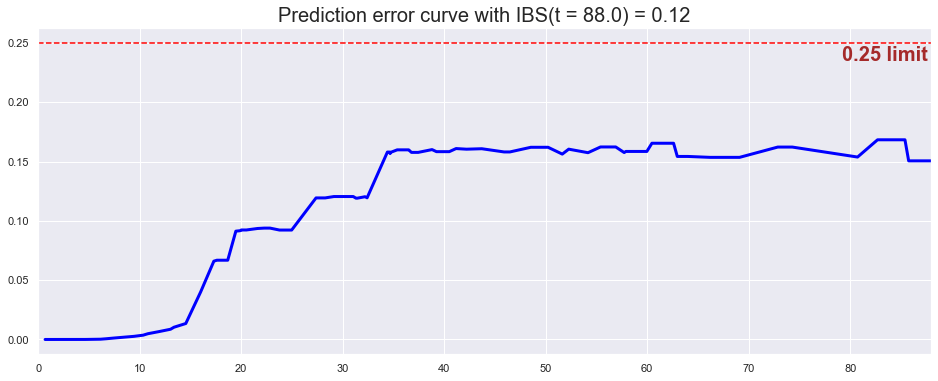

C-index: 0.63
IBS: 0.12

 3 of kfold 5


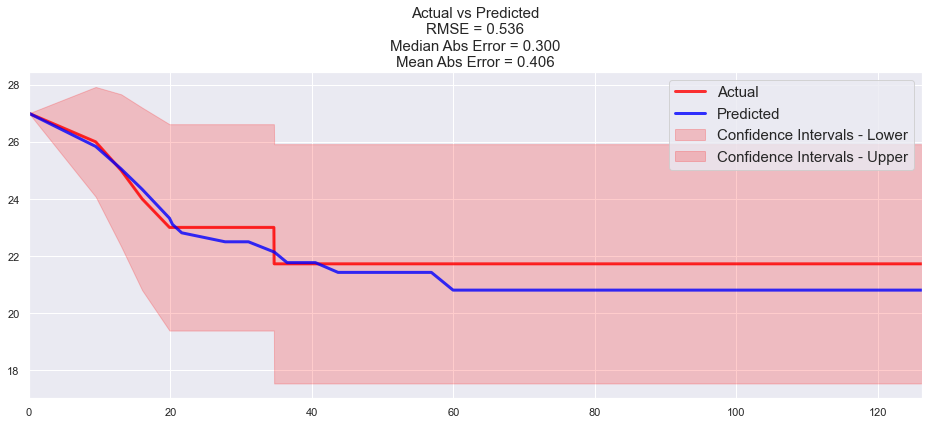

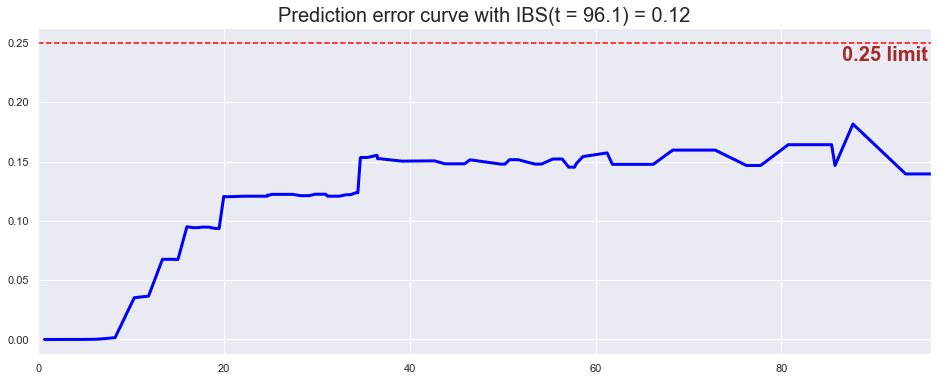

C-index: 0.75
IBS: 0.12

 4 of kfold 5


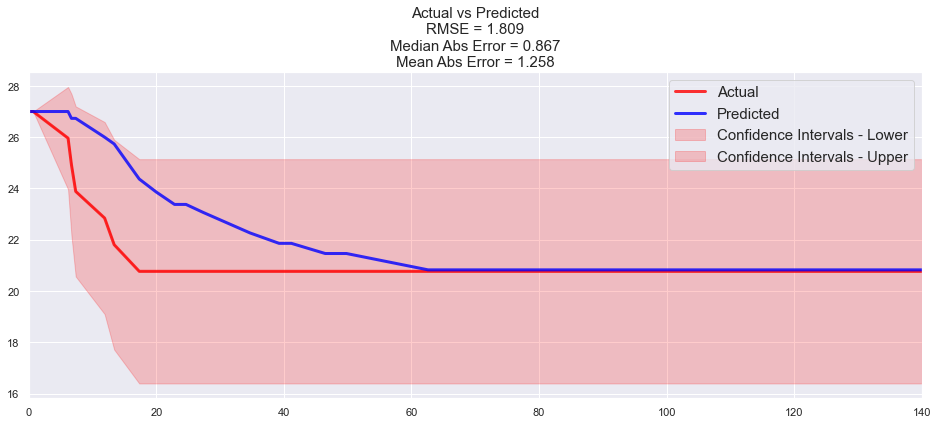

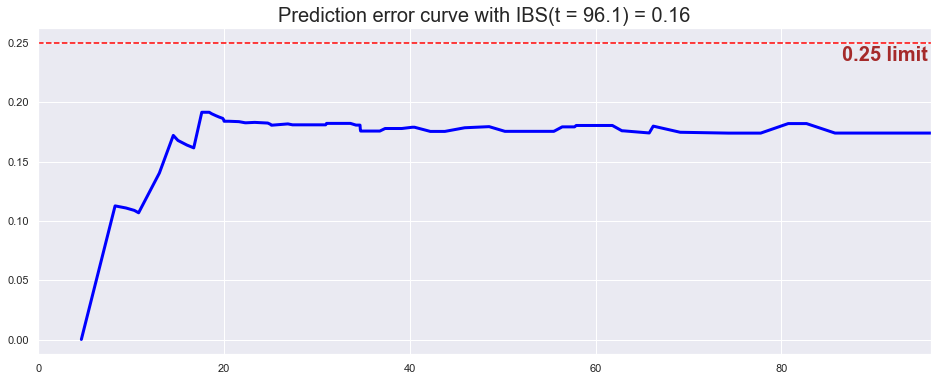

C-index: 0.68
IBS: 0.16

 5 of kfold 5


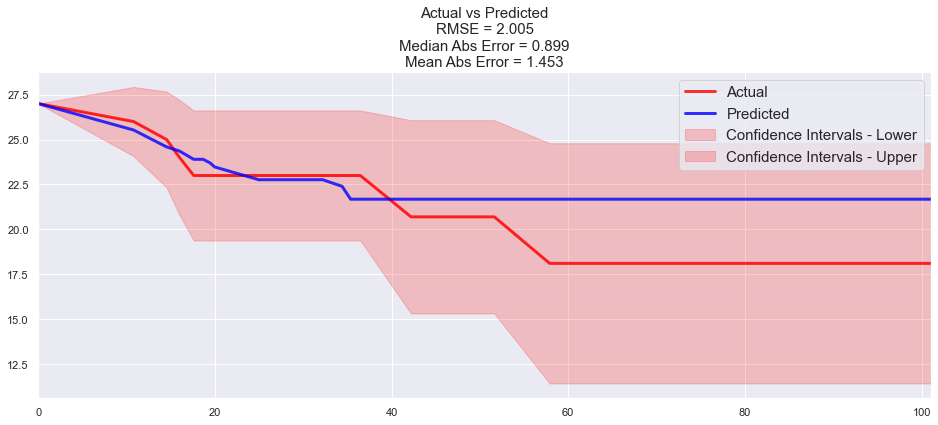

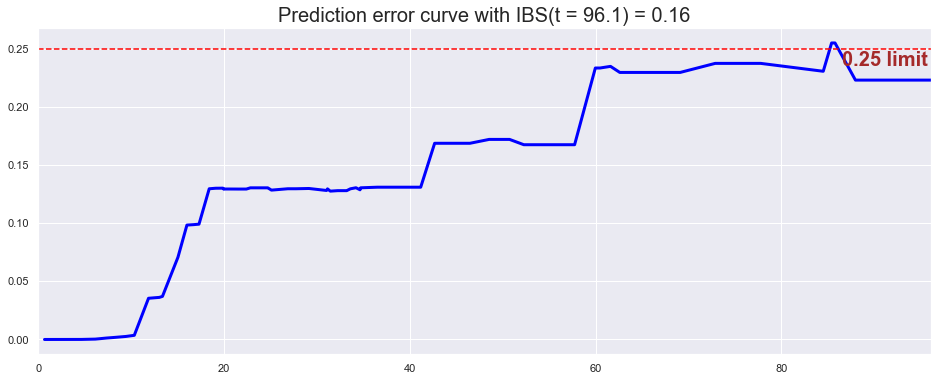

C-index: 0.64
IBS: 0.16
      Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       BMI>30  2.474573  2.771585  0.311017  0.291485
1          age  4.754850  1.914260  0.580773  0.300448
2       Hist_0  0.175869  2.550277  0.108210  0.105673
3  Node Status -0.416157  0.570503  0.000000  0.000000
4        Chemo -1.819734  1.400777  0.000000  0.000000
5           RT -2.380330  1.408507  0.000000  0.000000
6     Diabetes -2.305503  0.578017  0.000000  0.000000

 

Processing: postop_vars_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: postop_vars_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


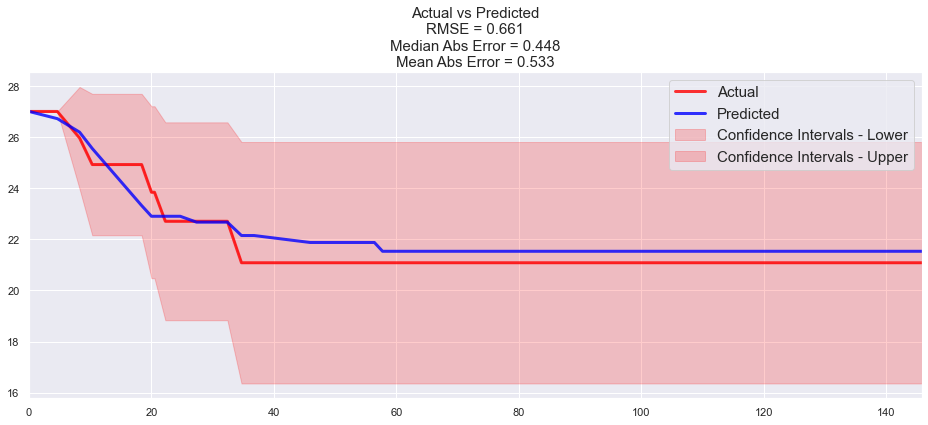

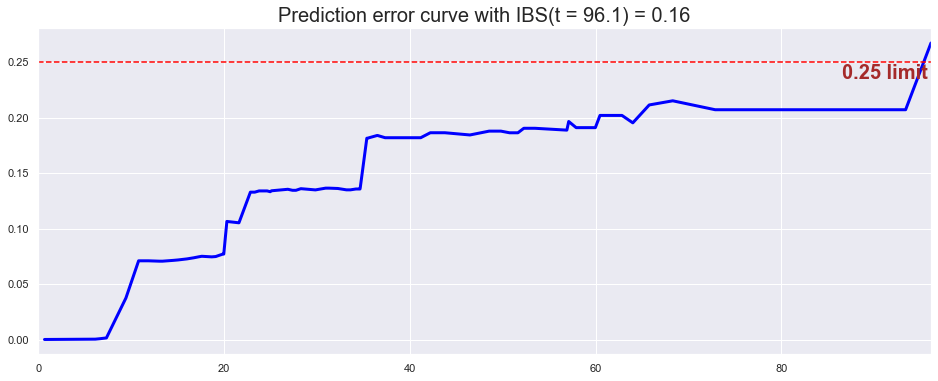

C-index: 0.57
IBS: 0.16

 2 of kfold 5


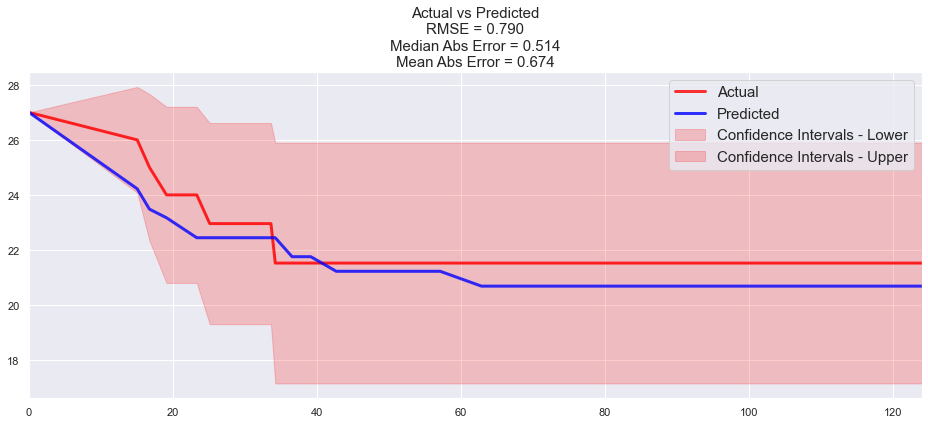

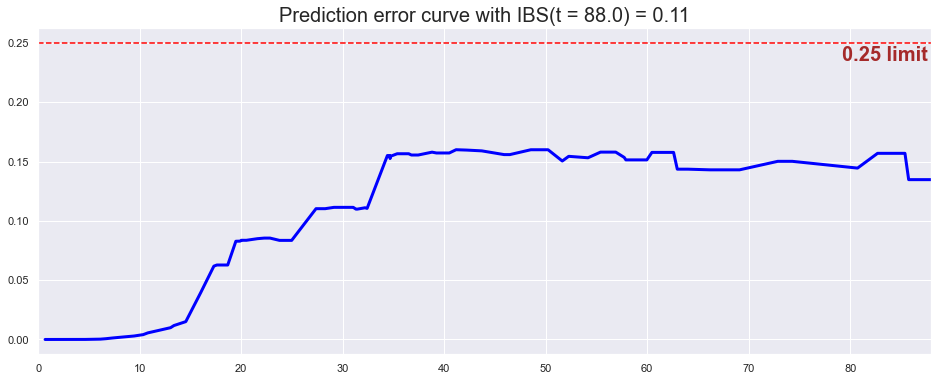

C-index: 0.68
IBS: 0.11

 3 of kfold 5


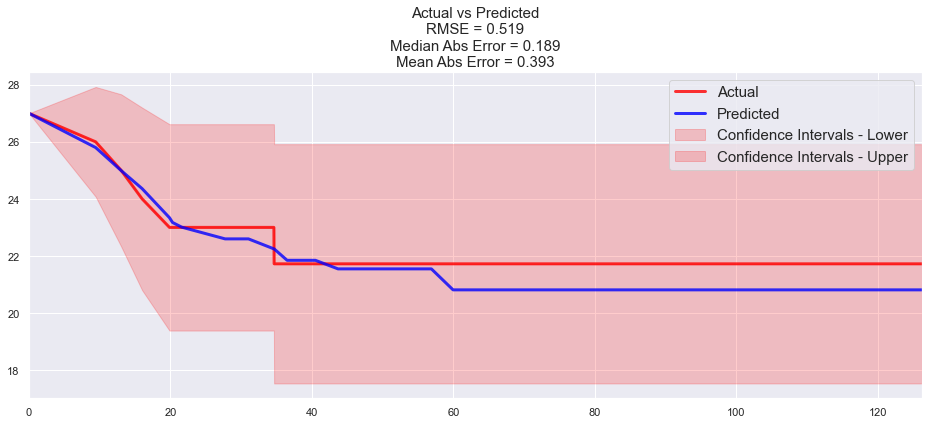

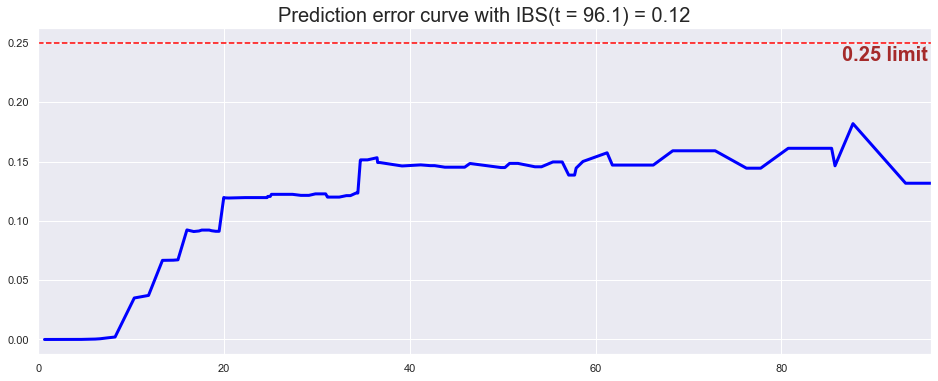

C-index: 0.67
IBS: 0.12

 4 of kfold 5


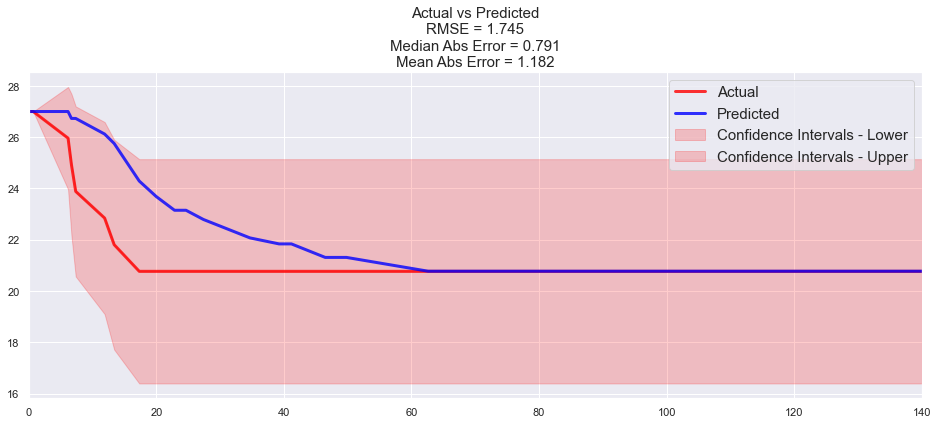

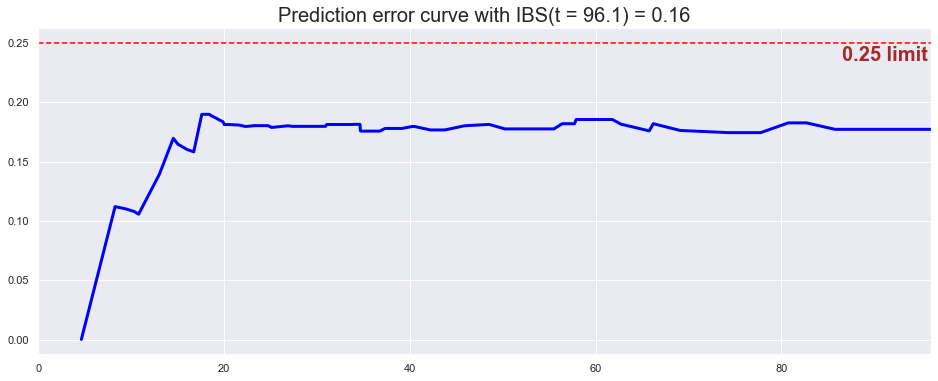

C-index: 0.65
IBS: 0.16

 5 of kfold 5


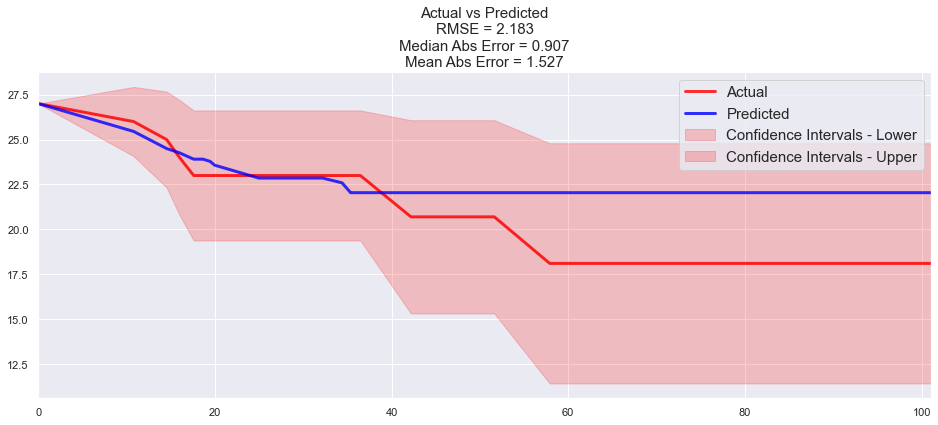

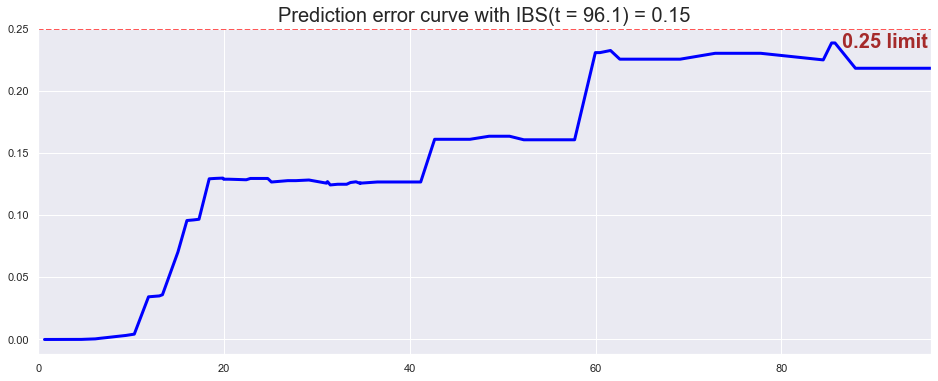

C-index: 0.60
IBS: 0.15
      Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0          age  4.532118  1.095254  0.818712  0.170538
1       BMI>30  0.135732  2.212273  0.140461  0.159978
2       Hist_0 -0.853404  1.321004  0.021476  0.042642
3  Node Status  0.000000  0.000000  0.000000  0.000000
4     Diabetes -0.930339  0.441249  0.000000  0.000000
5        Chemo -1.192681  1.143353  0.019351  0.043271
6           RT -1.236761  0.652307  0.000000  0.000000

 

Processing: complete_vars_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: complete_vars_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


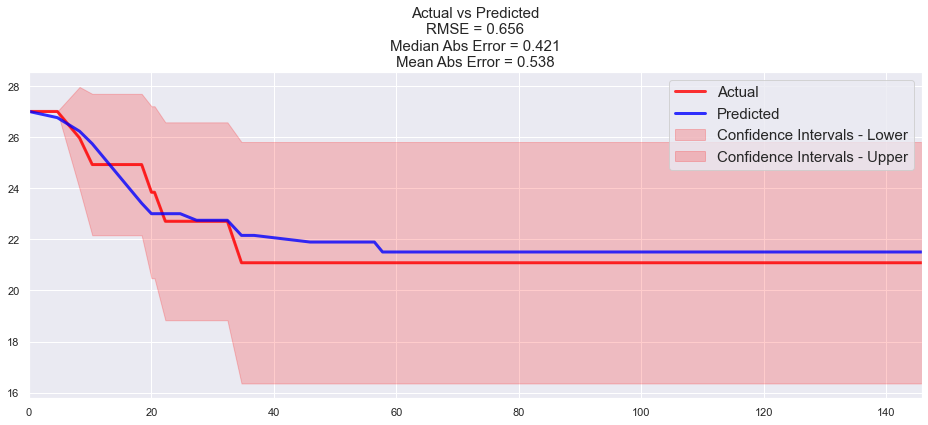

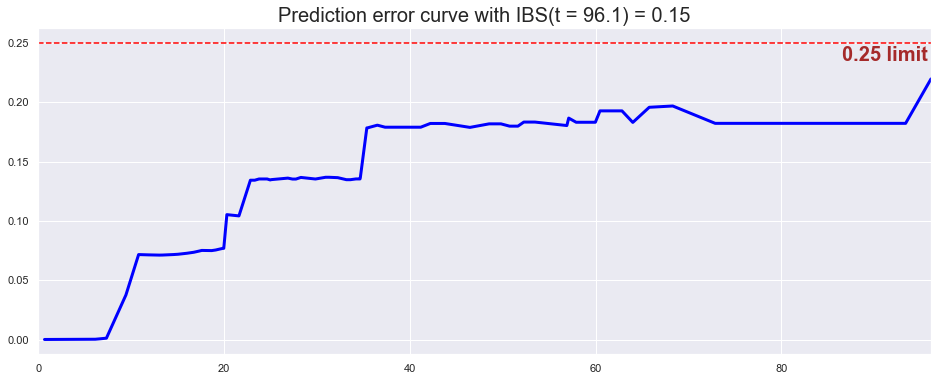

C-index: 0.60
IBS: 0.15

 2 of kfold 5


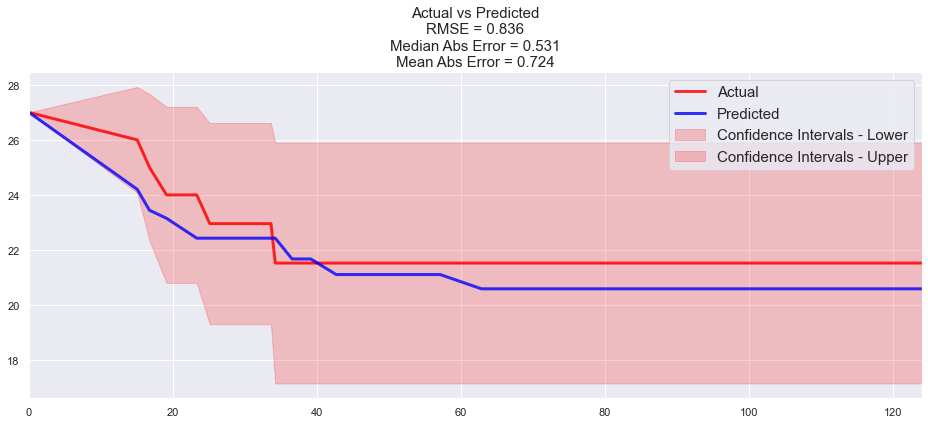

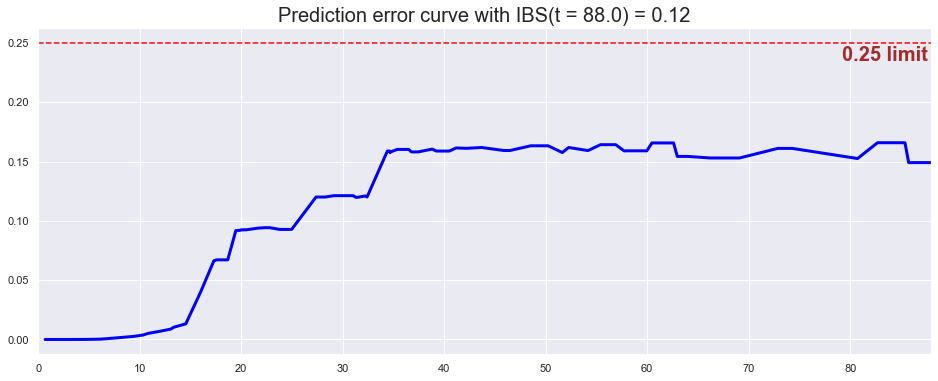

C-index: 0.67
IBS: 0.12

 3 of kfold 5


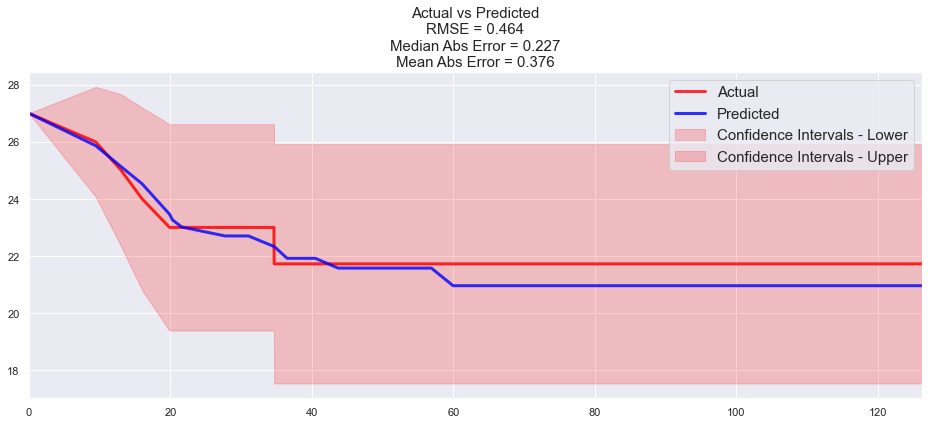

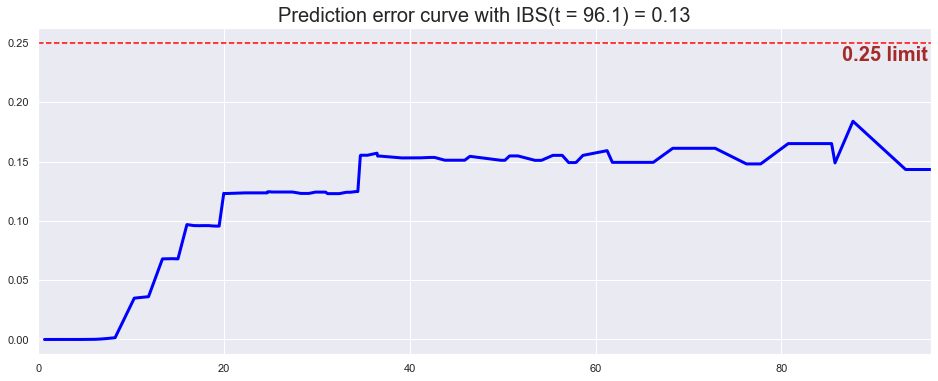

C-index: 0.72
IBS: 0.13

 4 of kfold 5


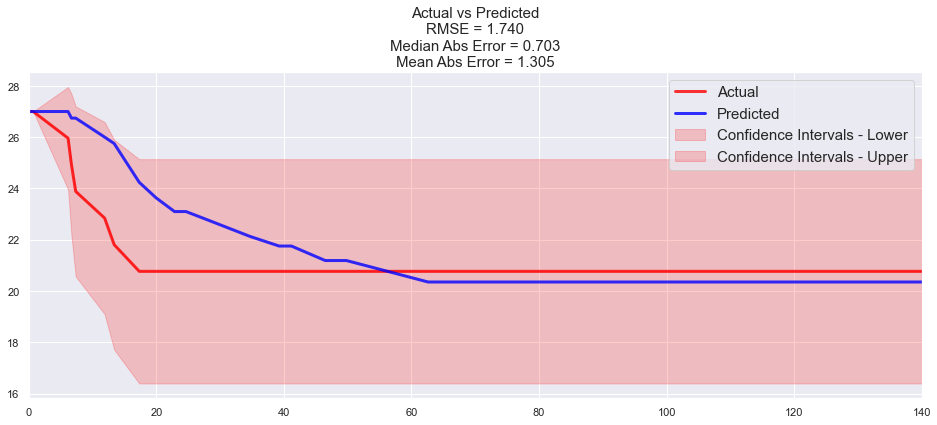

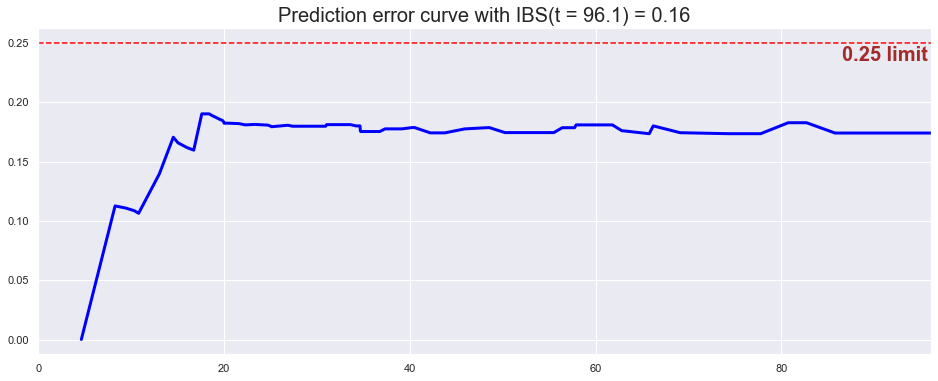

C-index: 0.66
IBS: 0.16

 5 of kfold 5


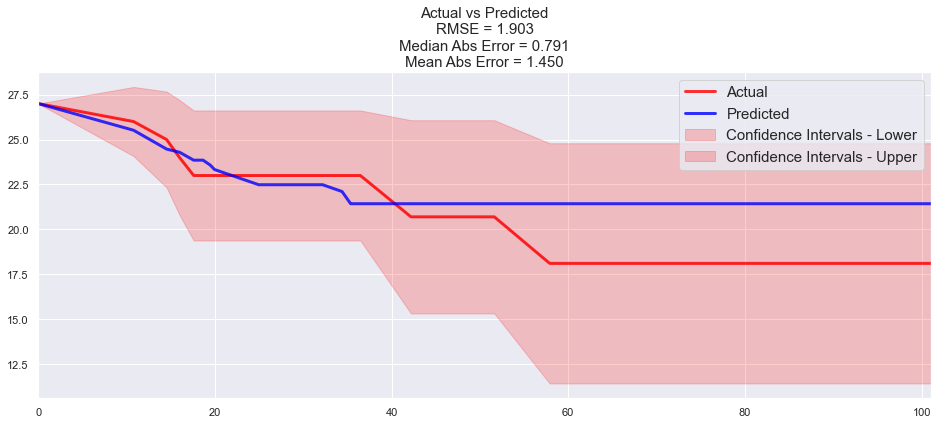

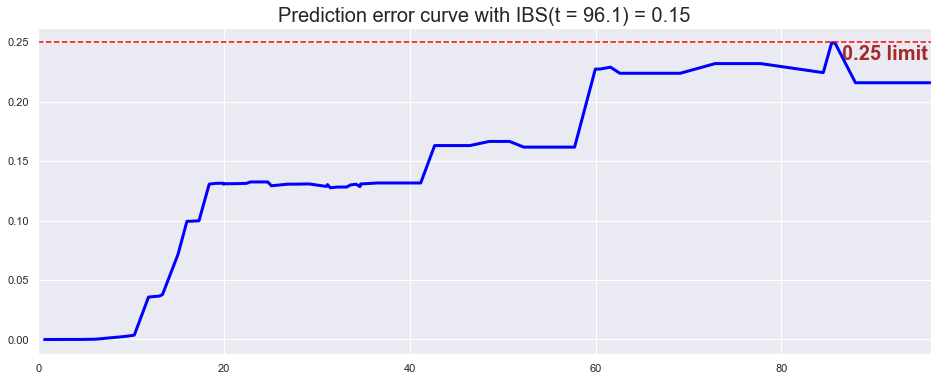

C-index: 0.61
IBS: 0.15
      Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       BMI>30  1.444289  2.260362  0.314850  0.316724
1          age  2.755113  1.177000  0.474153  0.235973
2       Hist_0  0.682783  1.707002  0.146286  0.161472
3           RT -0.736204  1.151091  0.013517  0.029528
4        Chemo -0.608032  1.121028  0.035754  0.076951
5  Node Status -0.404784  0.554295  0.000000  0.000000
6     Diabetes -0.838841  0.880095  0.015440  0.034524

 

Processing: radiomics_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: radiomics_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


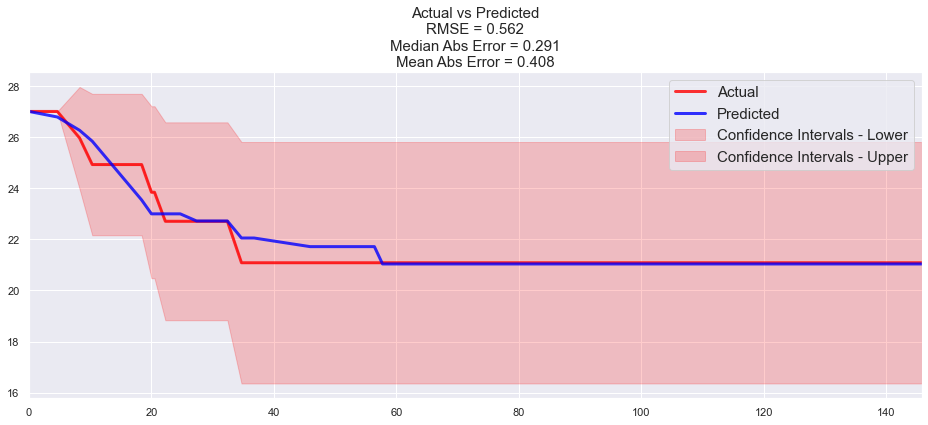

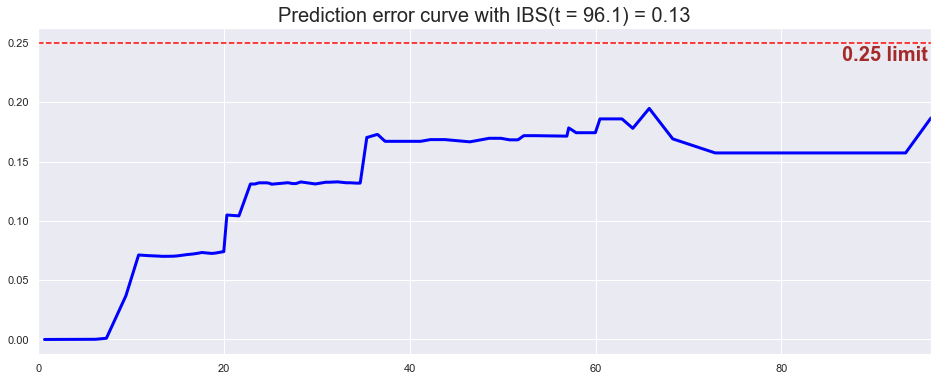

C-index: 0.72
IBS: 0.13

 2 of kfold 5


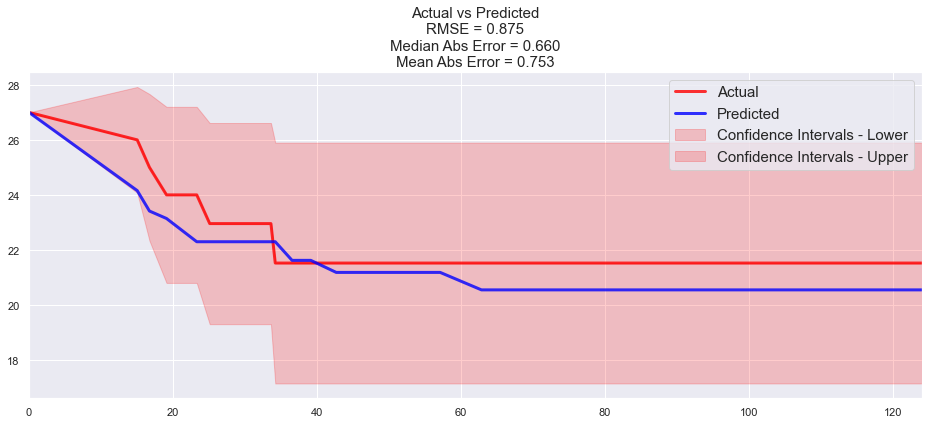

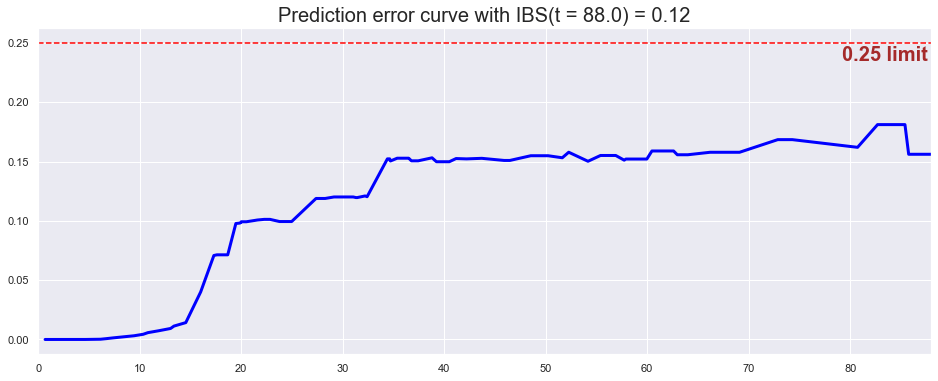

C-index: 0.75
IBS: 0.12

 3 of kfold 5


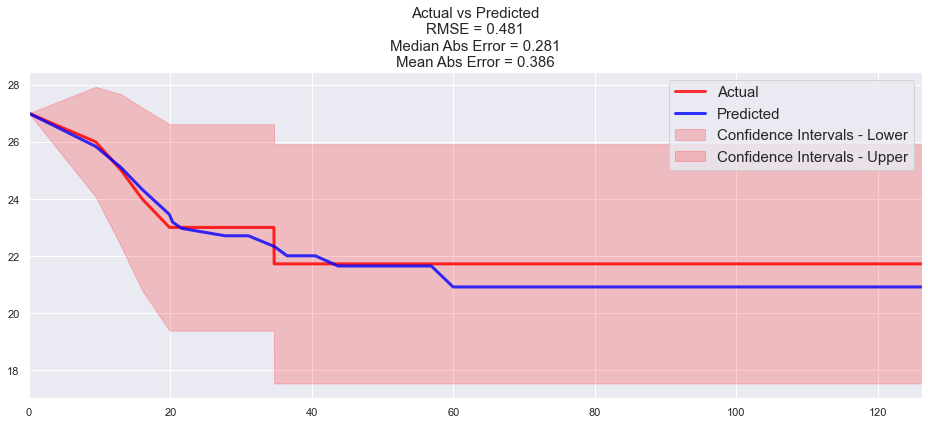

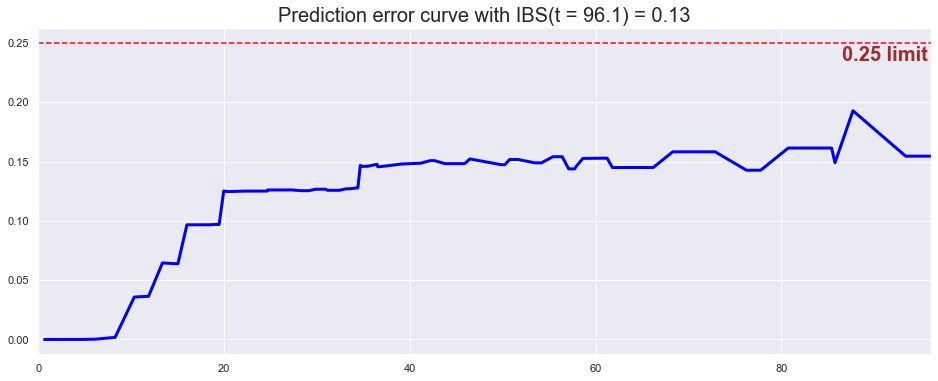

C-index: 0.65
IBS: 0.13

 4 of kfold 5


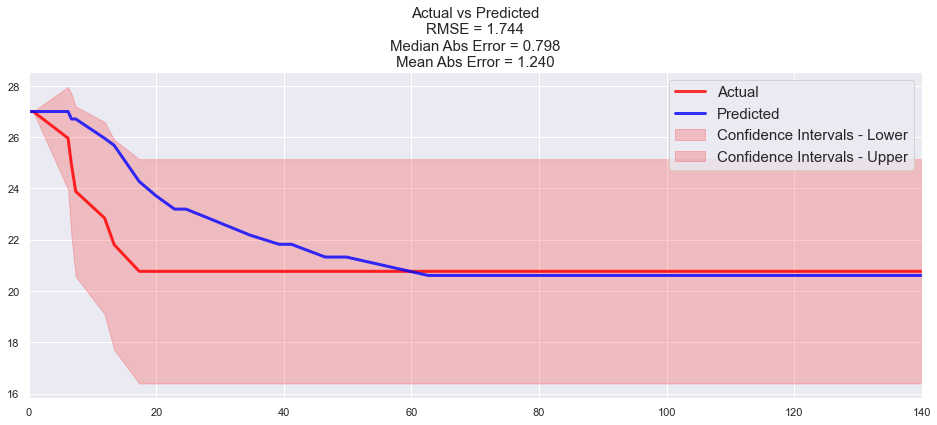

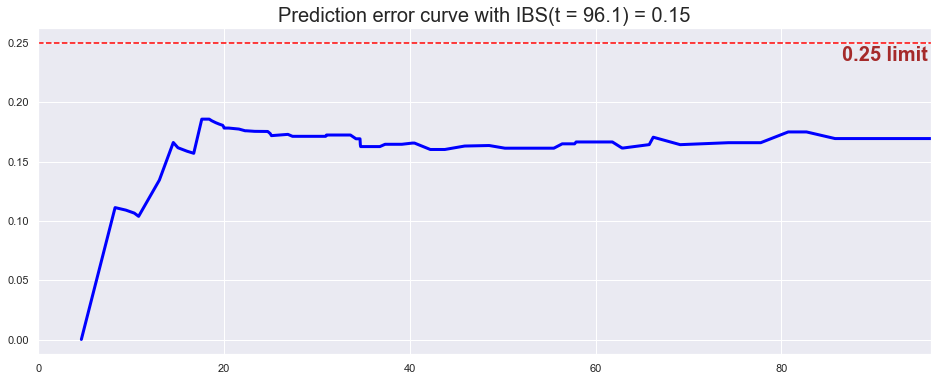

C-index: 0.78
IBS: 0.15

 5 of kfold 5


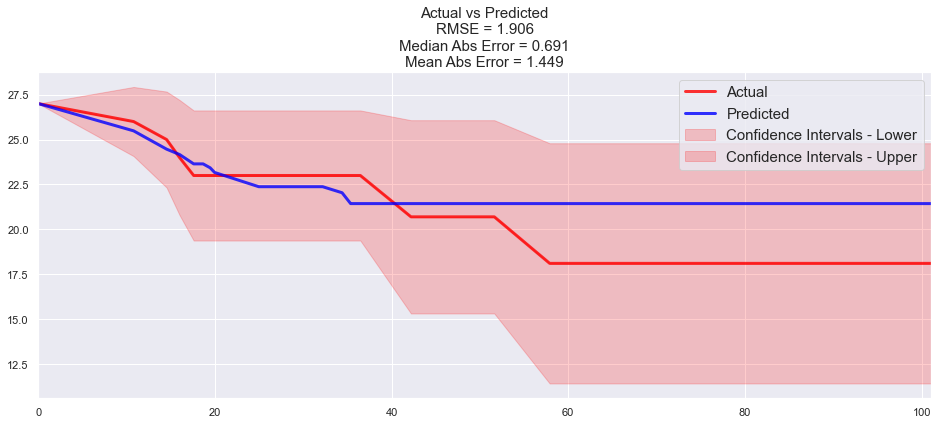

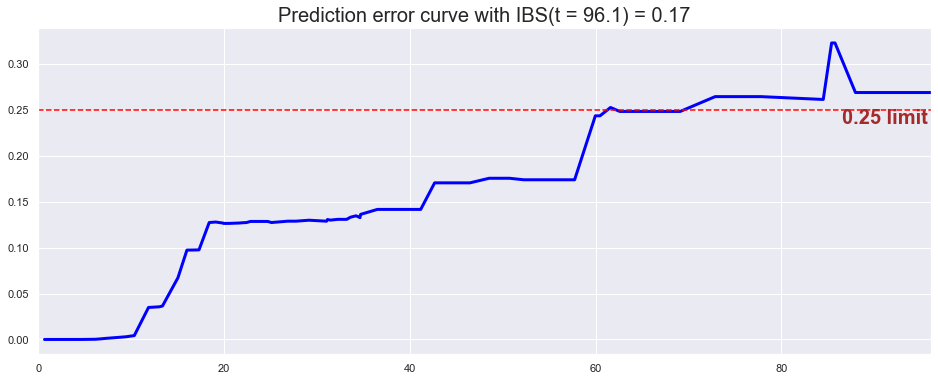

C-index: 0.60
IBS: 0.17
   Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0      FD51  4.022439  1.370572  0.175881  0.045429
1      FD54  3.090006  1.664872  0.134876  0.063857
2     LBP94  2.706628  1.442738  0.119736  0.064642
3    LBP116  2.575357  1.565466  0.112625  0.067349
4    LBP112  3.228286  1.267600  0.144901  0.065541
5    LBP101  0.765563  1.900766  0.052342  0.049266
6      FD27  4.469875  2.405876  0.202630  0.107946
7    LBP119 -0.340746  2.059713  0.025967  0.035758
8    LBP118 -0.836874  0.884321  0.000673  0.001506
9    LBP107 -1.396749  0.535083  0.000000  0.000000
10   LBP120 -1.688860  0.513757  0.000000  0.000000
11  ACM1_12 -1.218980  1.410160  0.012081  0.027014
12   LBP106 -0.540321  1.433135  0.018288  0.026091

 

Processing: preop_and_radiomics.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: preop_and_radiomics.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter c

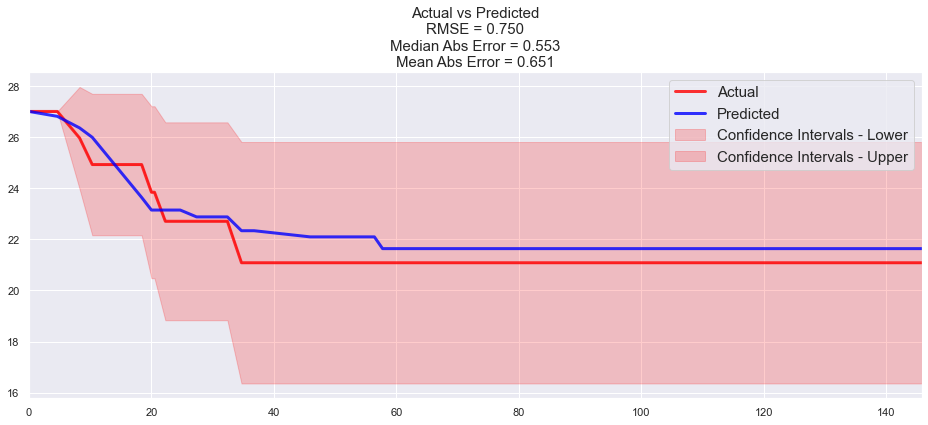

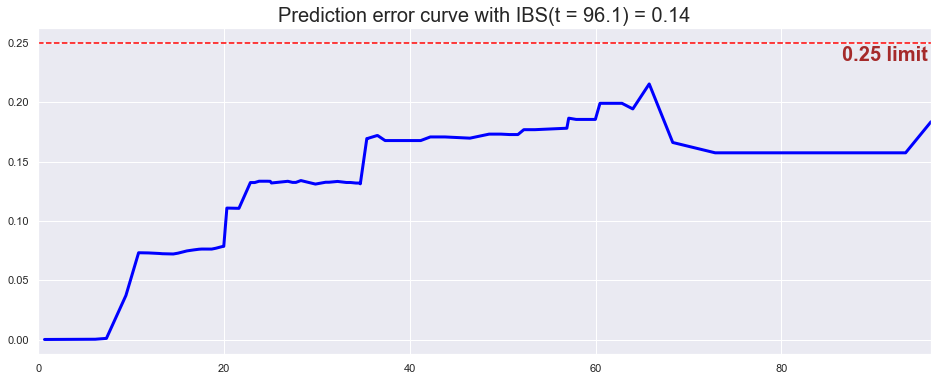

C-index: 0.73
IBS: 0.14

 2 of kfold 5


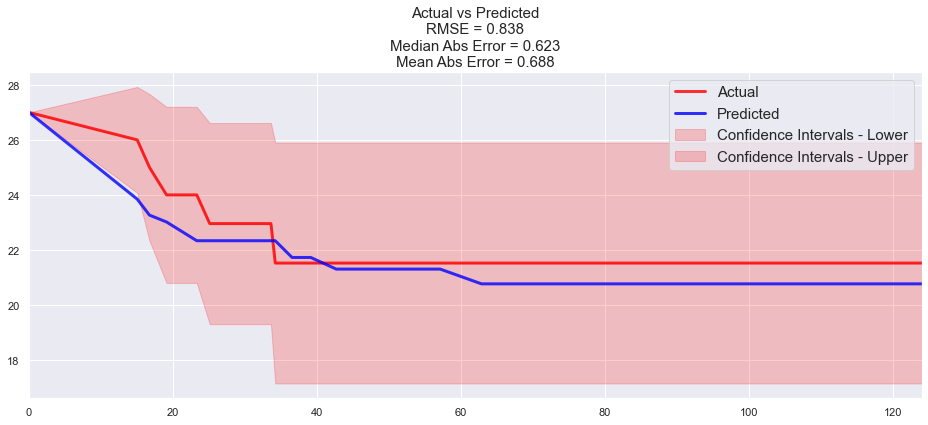

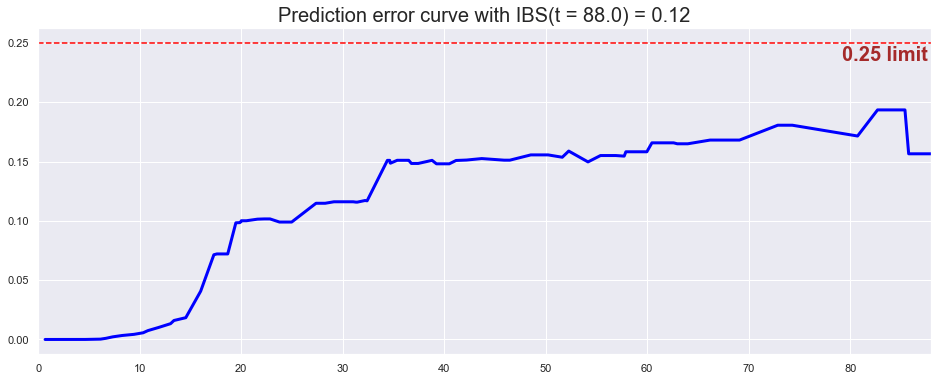

C-index: 0.69
IBS: 0.12

 3 of kfold 5


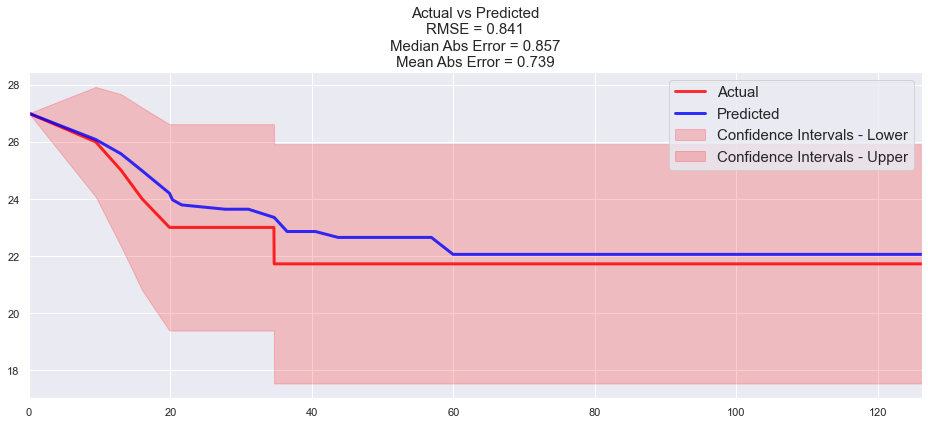

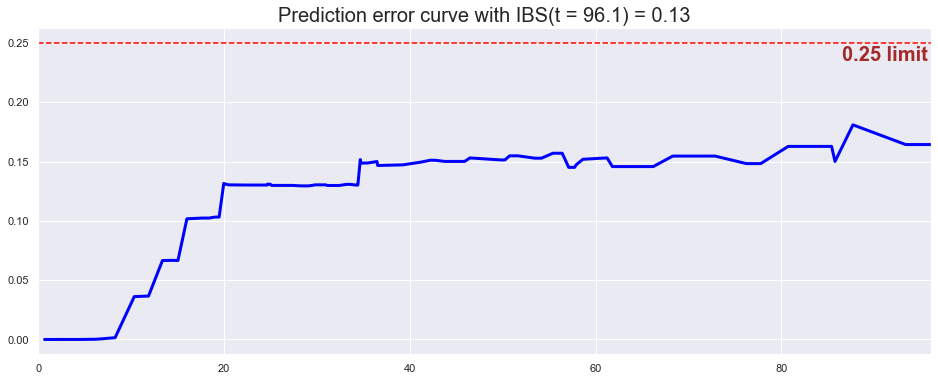

C-index: 0.65
IBS: 0.13

 4 of kfold 5


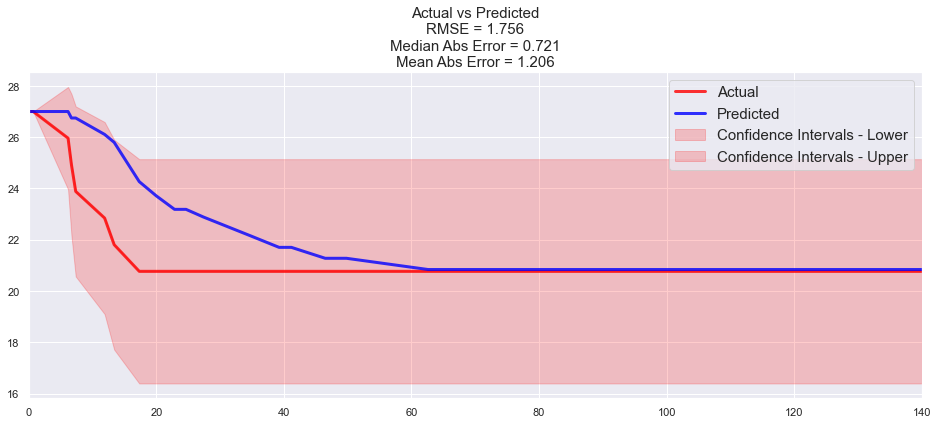

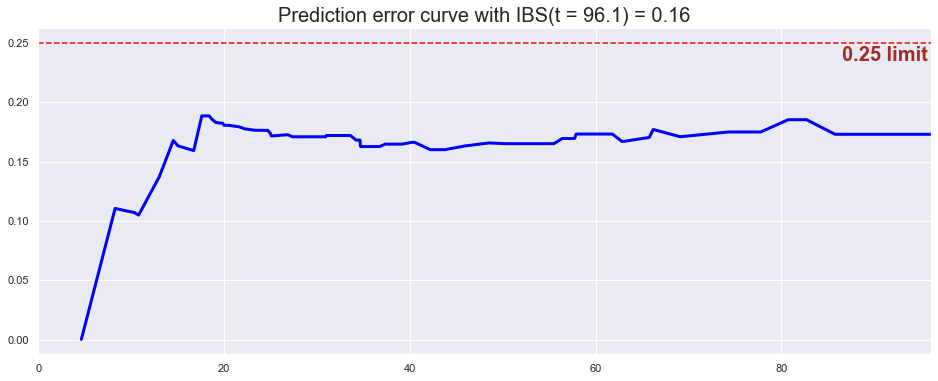

C-index: 0.72
IBS: 0.16

 5 of kfold 5


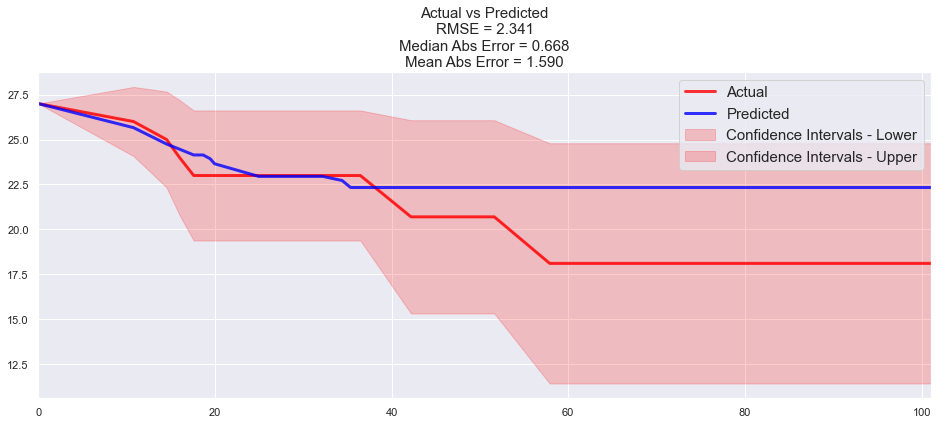

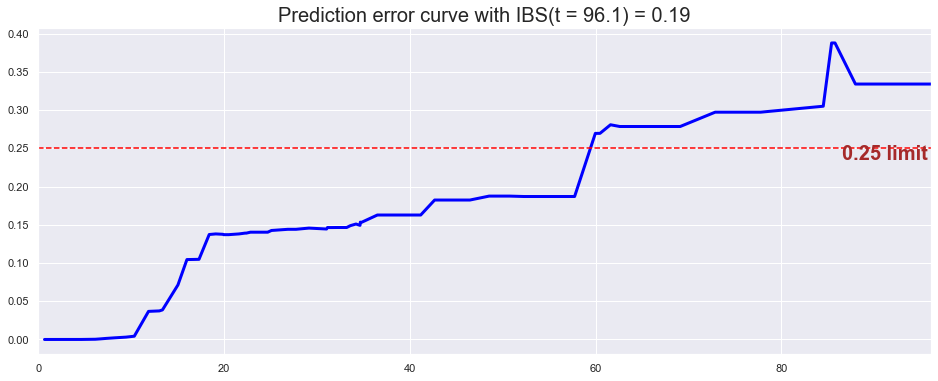

C-index: 0.53
IBS: 0.19
    Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       FD51  1.608501  1.782880  0.159627  0.138736
1     LBP116  1.083566  2.043228  0.126578  0.175243
2       FD54  1.891649  0.887275  0.206023  0.106555
3     LBP112  2.481771  1.032805  0.274179  0.126773
4      LBP94  0.700728  0.792820  0.089620  0.053876
5     LBP118 -0.327454  0.902358  0.016711  0.031961
6    ACM1_12  0.024601  0.816590  0.039806  0.057636
7   race_1.0  0.000000  0.000000  0.000000  0.000000
8     LBP119 -0.836848  0.607679  0.000000  0.000000
9     LBP106 -0.164815  1.532403  0.055001  0.119668
10    LBP101  0.123092  0.462672  0.028252  0.032675
11    LBP107 -1.009077  0.799421  0.004203  0.009397
12    LBP120 -1.450023  0.760323  0.000000  0.000000

 

Processing: postop_and_radiomics.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: postop_and_radiomics.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best 

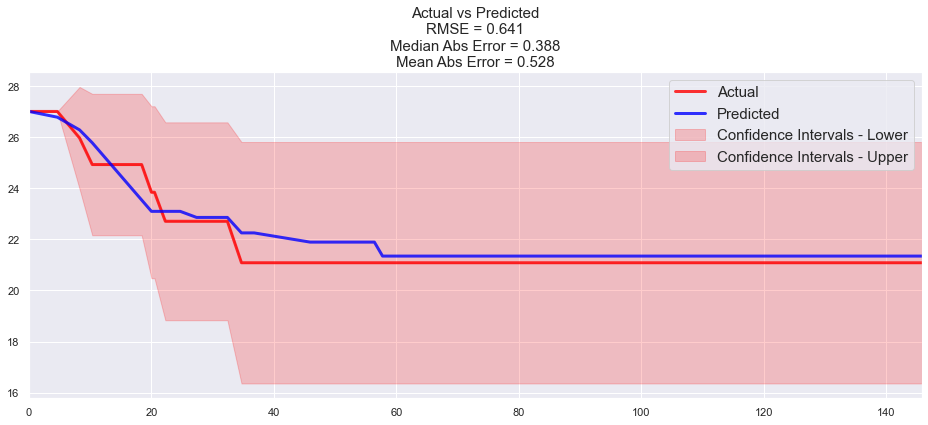

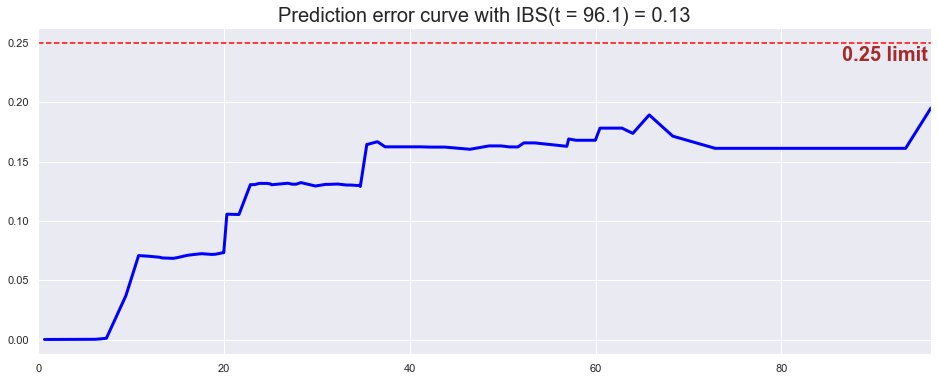

C-index: 0.74
IBS: 0.13

 2 of kfold 5


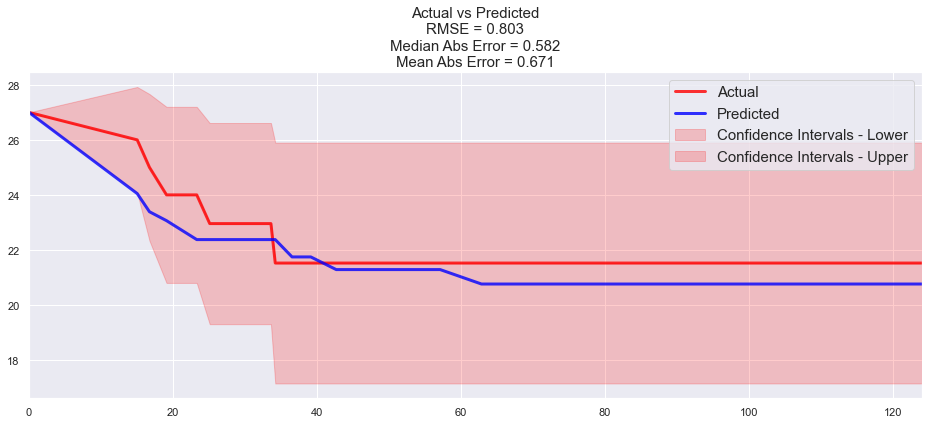

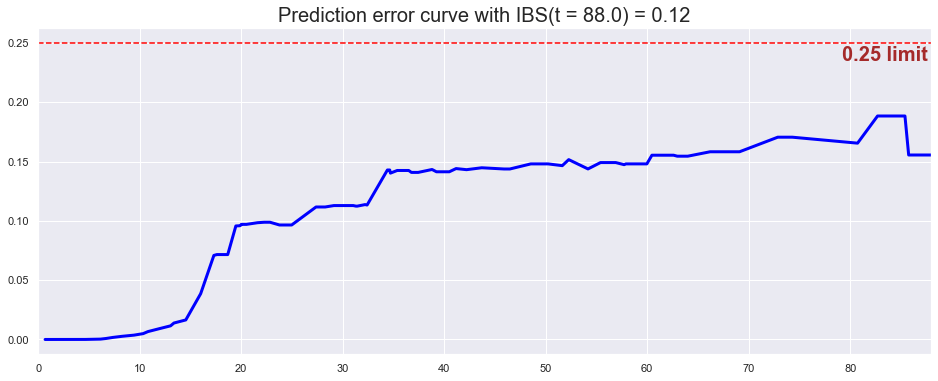

C-index: 0.78
IBS: 0.12

 3 of kfold 5


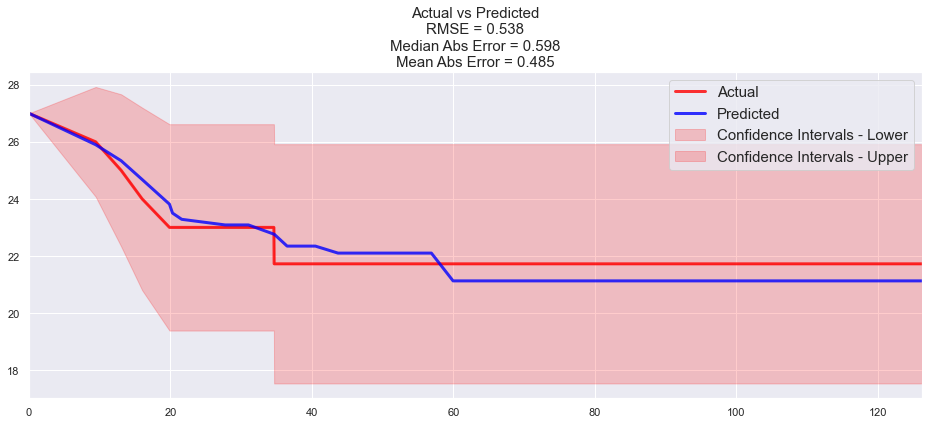

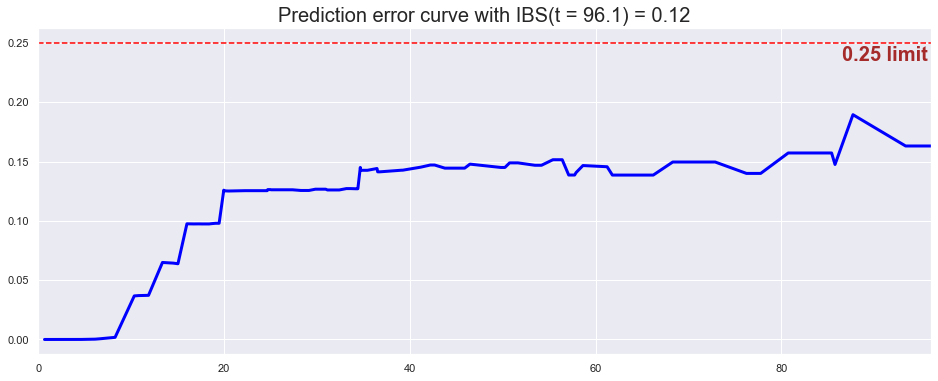

C-index: 0.67
IBS: 0.12

 4 of kfold 5


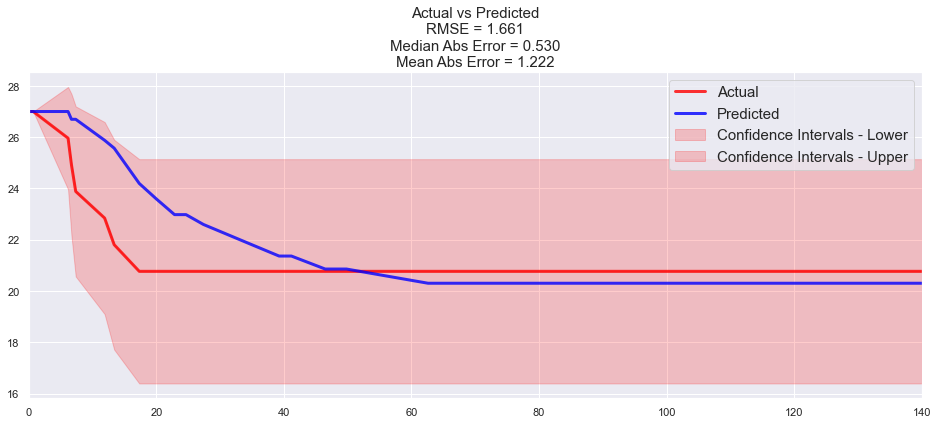

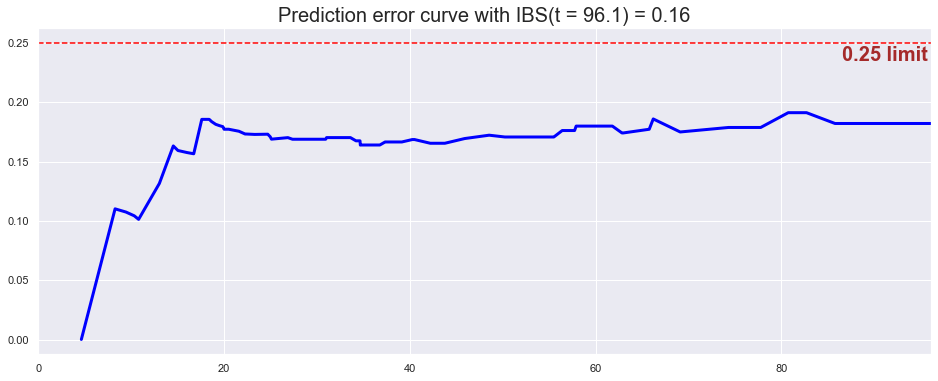

C-index: 0.73
IBS: 0.16

 5 of kfold 5


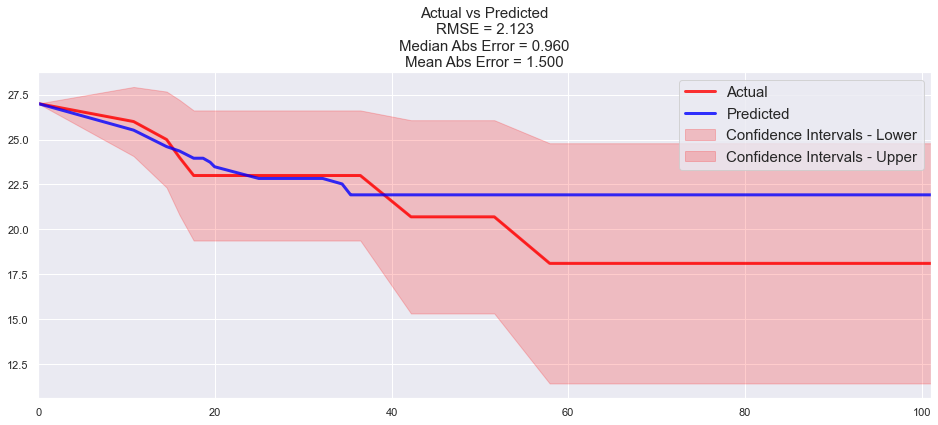

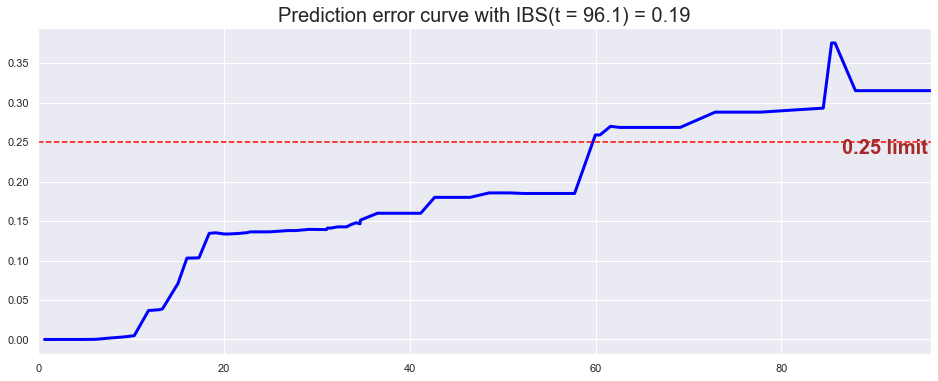

C-index: 0.59
IBS: 0.19
    Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       FD51  2.516785  1.342661  0.173161  0.075320
1     LBP116  1.545901  1.235969  0.113499  0.070378
2     LBP112  2.740463  0.448056  0.232477  0.122094
3       FD54  1.579717  1.072905  0.109748  0.067314
4      LBP94  2.041285  0.249362  0.167768  0.065447
5     LBP101  1.214978  1.186079  0.097134  0.067964
6     LBP120 -0.715404  1.296174  0.013928  0.029376
7    ACM1_12  0.198883  1.363979  0.041987  0.035614
8   race_1.0  0.000000  0.000000  0.000000  0.000000
9     LBP107 -0.517831  0.781272  0.009979  0.022314
10    LBP106 -0.462465  1.307467  0.024921  0.034367
11    LBP118 -0.981807  0.617243  0.000222  0.000497
12    LBP119 -0.841296  1.400365  0.015175  0.030466

 

Processing: complete_and_radiomics.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: complete_and_radiomics.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with b

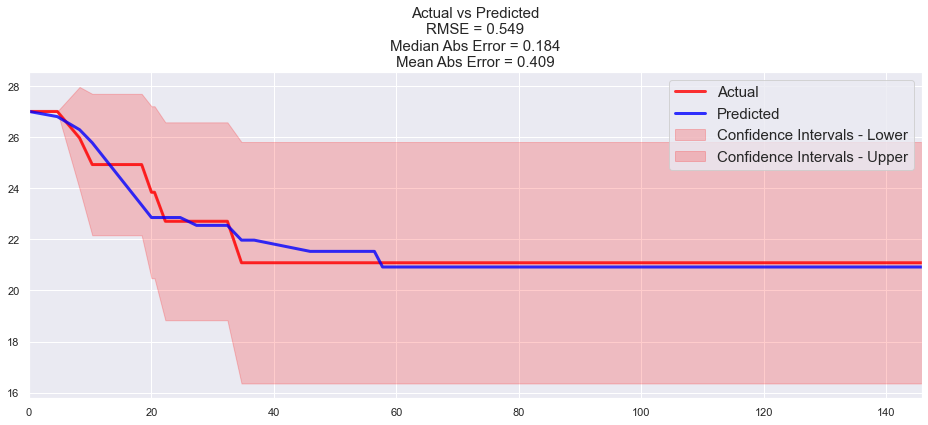

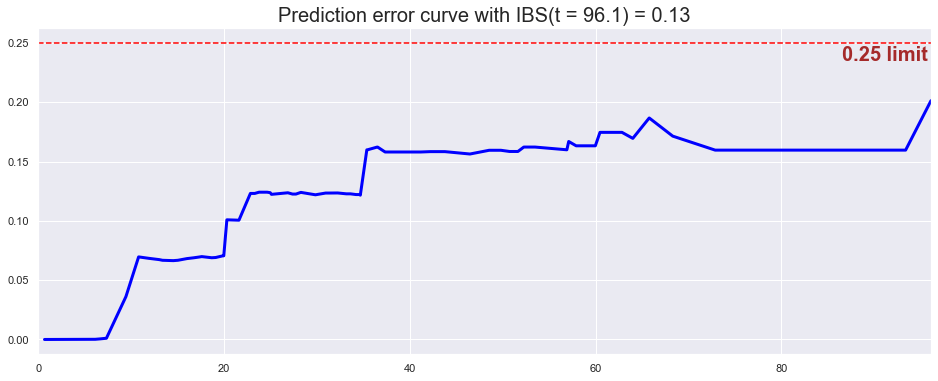

C-index: 0.73
IBS: 0.13

 2 of kfold 5


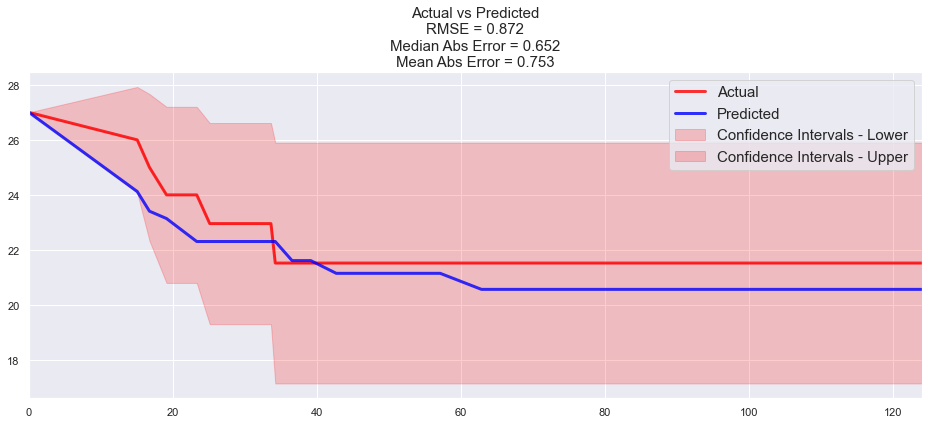

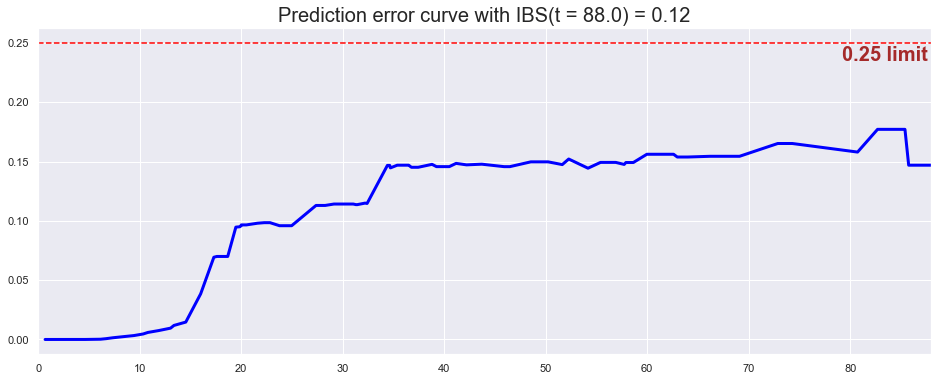

C-index: 0.74
IBS: 0.12

 3 of kfold 5


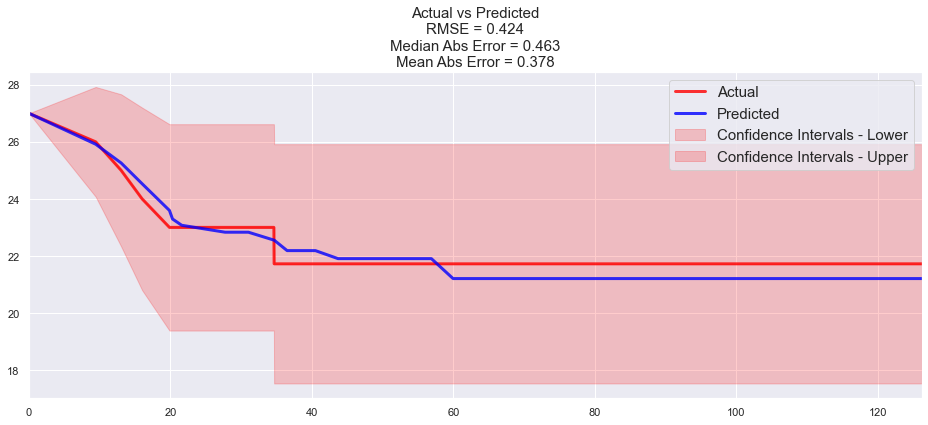

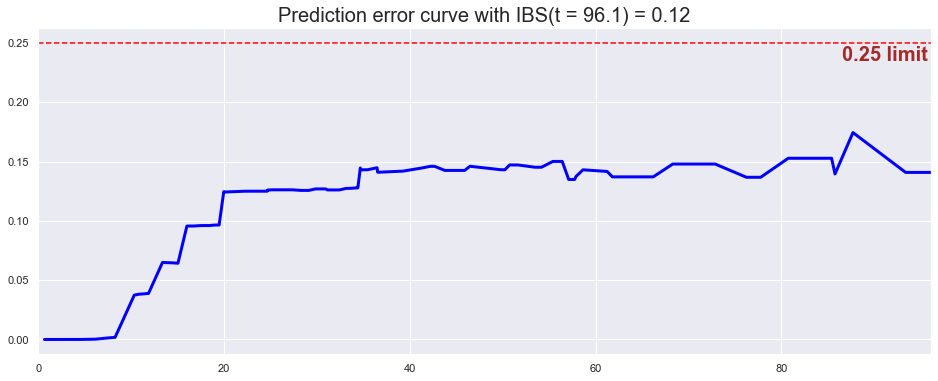

C-index: 0.68
IBS: 0.12

 4 of kfold 5


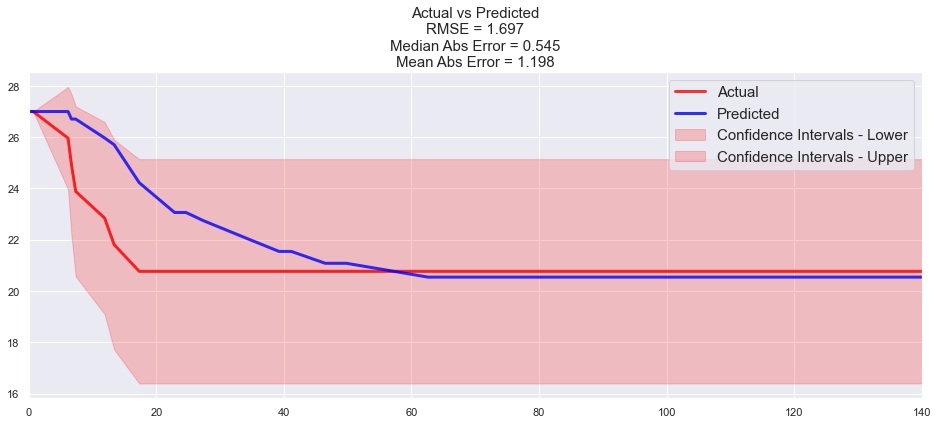

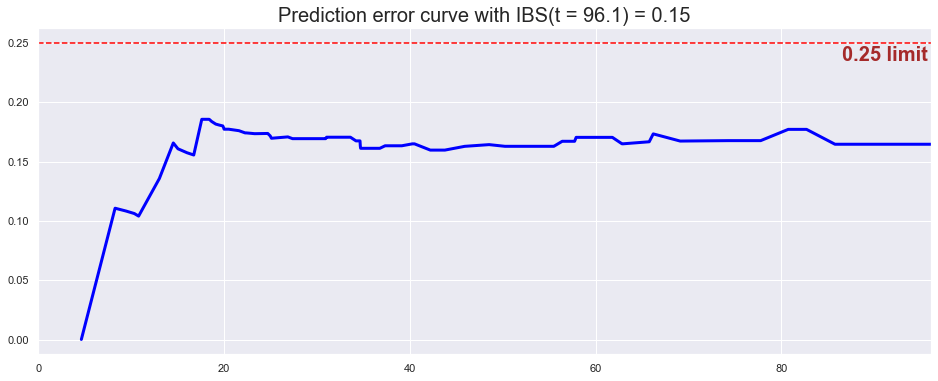

C-index: 0.78
IBS: 0.15

 5 of kfold 5


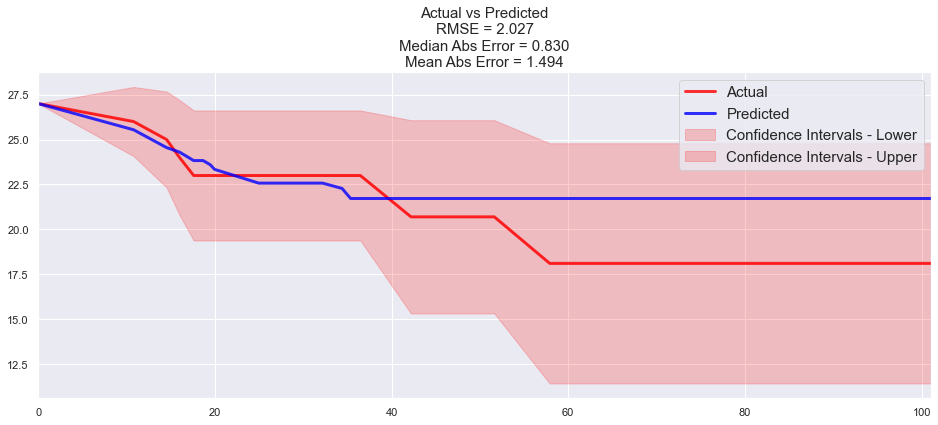

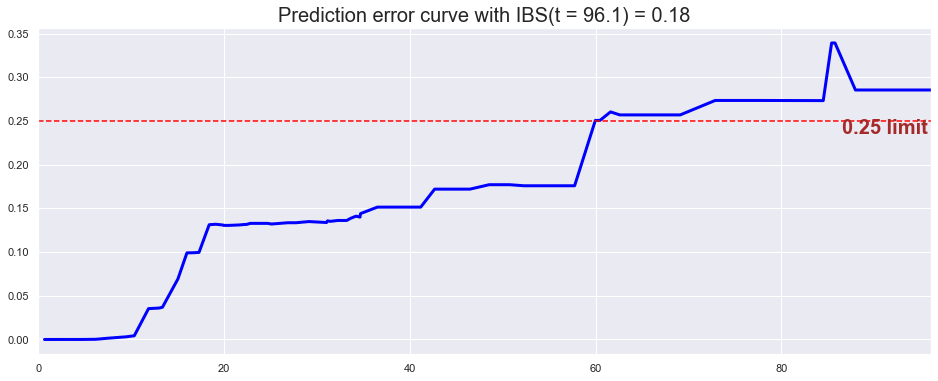

C-index: 0.54
IBS: 0.18
    Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       FD51  3.890386  1.900527  0.165404  0.042296
1       FD54  2.960905  2.074402  0.121988  0.064151
2     LBP116  3.717950  0.962631  0.171675  0.050367
3      LBP94  2.247779  2.095573  0.102922  0.070511
4     LBP112  4.277216  2.117869  0.220944  0.166693
5        age  3.002654  2.487490  0.130142  0.099049
6     LBP107 -0.932022  1.352692  0.008914  0.019933
7     LBP101  1.107616  1.112472  0.049780  0.046440
8   race_1.0  0.000000  0.000000  0.000000  0.000000
9     LBP118 -1.100559  1.243599  0.000000  0.000000
10   ACM1_12 -0.313461  1.236820  0.014071  0.023610
11    LBP120 -2.231795  0.640913  0.000000  0.000000
12    LBP119 -1.668980  0.684572  0.000000  0.000000
13    LBP106 -0.171443  1.165702  0.014160  0.020655

 

Processing: unfiltered_radiomics.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: unfiltered_radiomics.csv

Loading existing gridsea

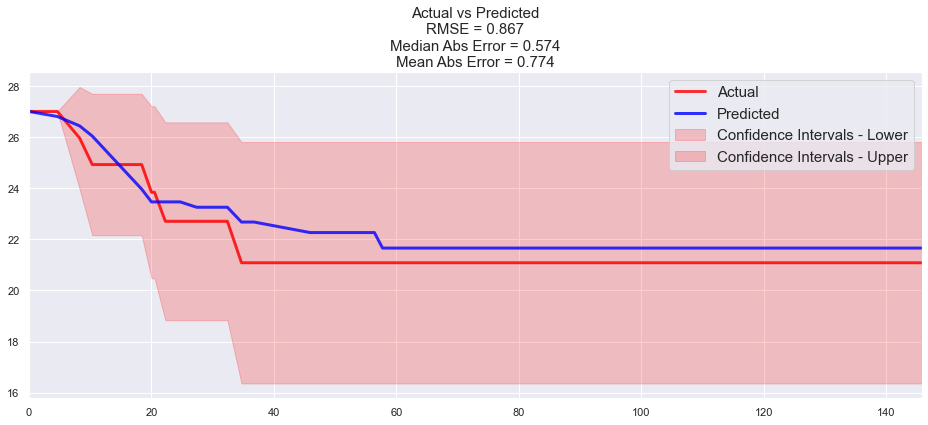

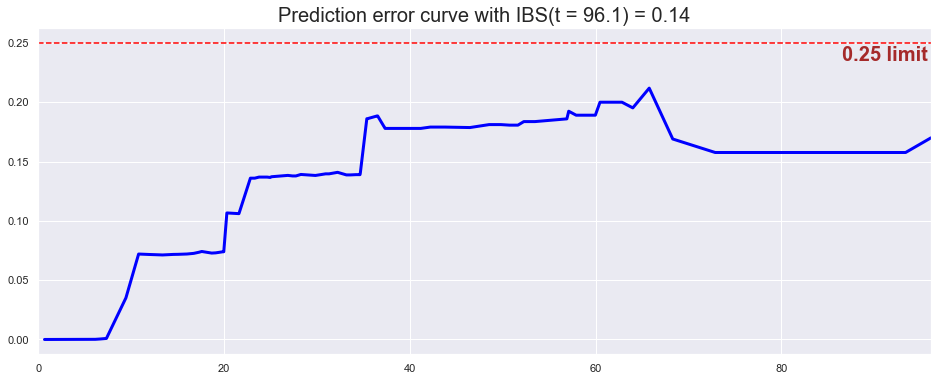

C-index: 0.59
IBS: 0.14

 2 of kfold 5


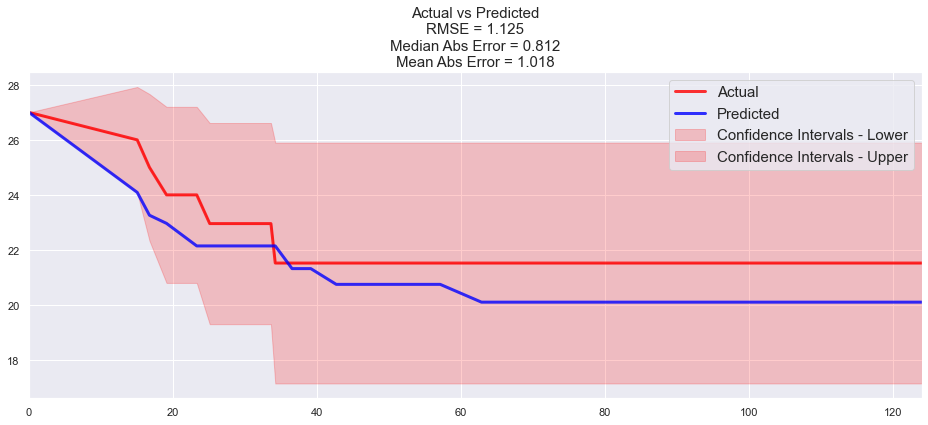

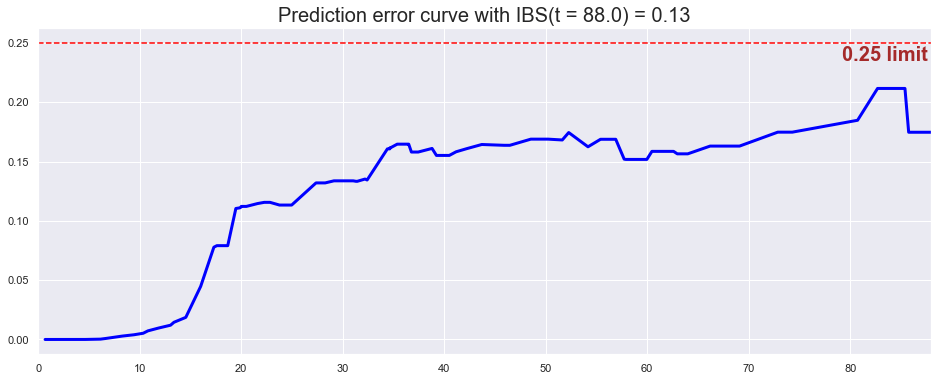

C-index: 0.59
IBS: 0.13

 3 of kfold 5


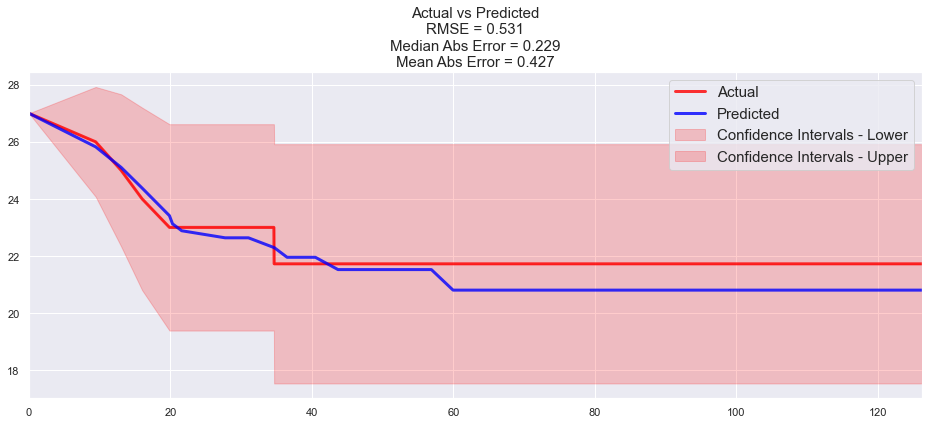

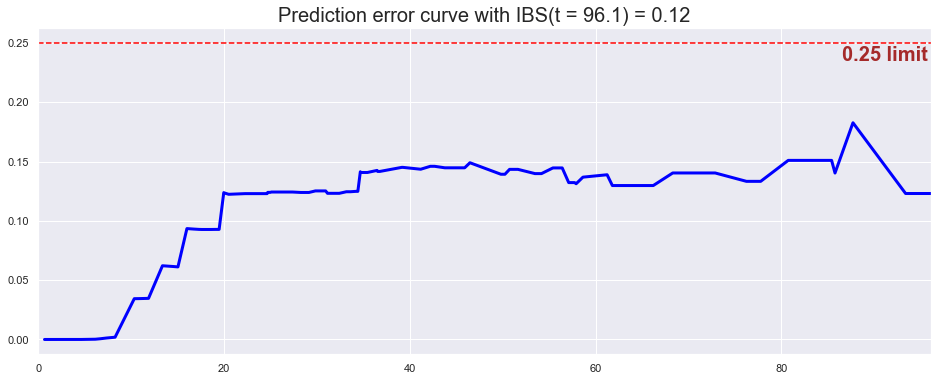

C-index: 0.70
IBS: 0.12

 4 of kfold 5


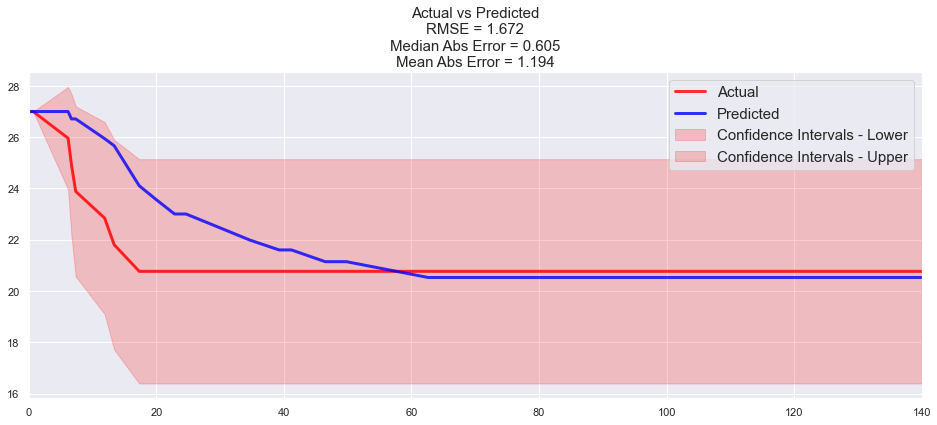

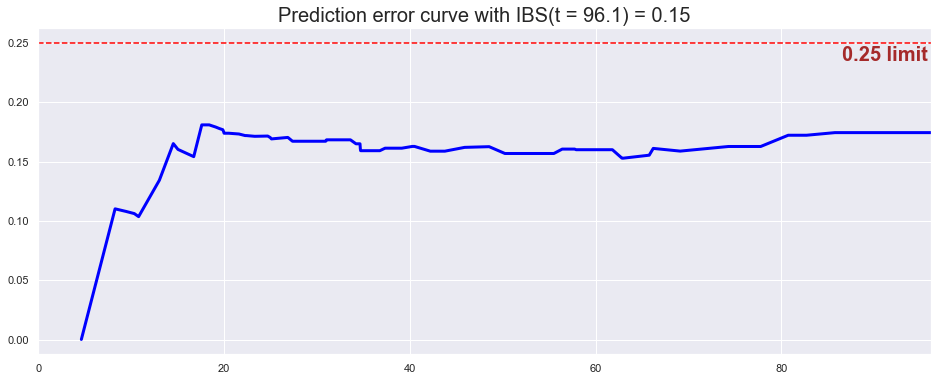

C-index: 0.76
IBS: 0.15

 5 of kfold 5


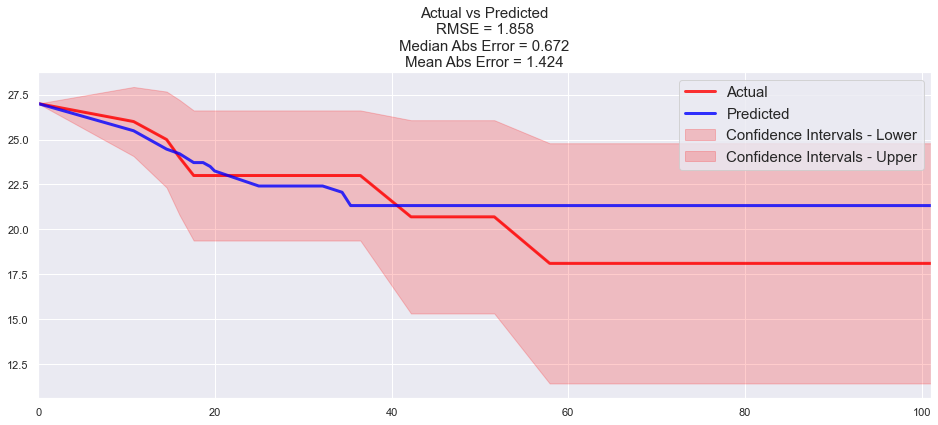

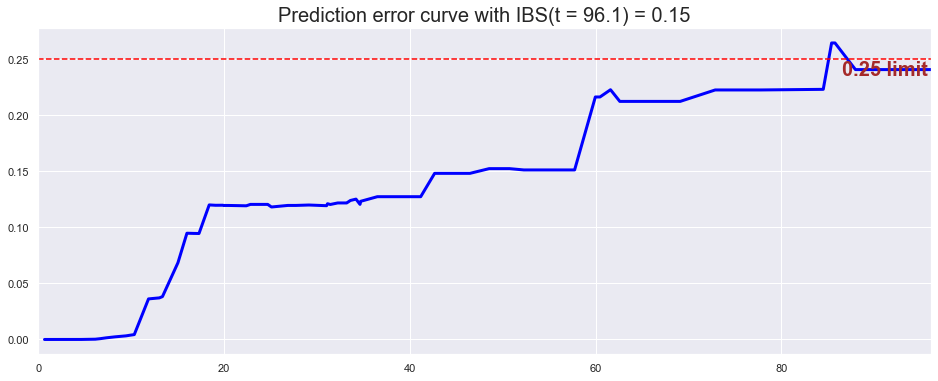

C-index: 0.65
IBS: 0.15
    Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0       RLM8  1.570730  1.107874  0.014050  0.010034
1     LBP127  2.010521  0.924560  0.017859  0.007453
2       FD51  1.150806  1.350549  0.012187  0.009010
3       FD50  0.906327  1.034879  0.008274  0.009410
4     LBP123  1.162274  1.711908  0.013207  0.009705
..       ...       ...       ...       ...       ...
259   LBP109 -0.326631  0.865657  0.001728  0.003865
260    LBP45  0.369289  1.070732  0.005184  0.007102
261     FD31  0.526750  1.060423  0.006729  0.005950
262    LBP40 -0.682683  0.645119  0.000000  0.000000
263    LBP72 -0.337299  1.034662  0.001693  0.003785

[264 rows x 5 columns]

 



,Data,Best Gridsearch CI,CI Avg,CI STD,IBS Avg,IBS STD,Num Trees,Max Depth,Min Node
0,preop_vars_only.csv,0.675010,0.665413,0.053559,0.141640,0.018979,300.0,1.0,4.0
1,postop_vars_only.csv,0.679063,0.633827,0.046739,0.141210,0.021837,100.0,15.0,10.0
2,complete_vars_only.csv,0.676695,0.652836,0.047074,0.141152,0.017777,100.0,1.0,3.0
3,radiomics_only.csv,0.721176,0.700670,0.072087,0.140359,0.020838,300.0,1.0,15.0
4,preop_and_radiomics.csv,0.727760,0.661628,0.082337,0.147014,0.028676,100.0,10.0,5.0
5,postop_and_radiomics.csv,0.716317,0.700004,0.072845,0.143818,0.028861,100.0,10.0,12.0
6,complete_and_radiomics.csv,0.720621,0.695071,0.092305,0.139041,0.025241,300.0,15.0,15.0
7,unfiltered_radiomics.csv,0.721176,0.656707,0.070555,0.137021,0.014119,300.0,1.0,15.0


In [343]:
results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

results_DF


 1 of kfold 5


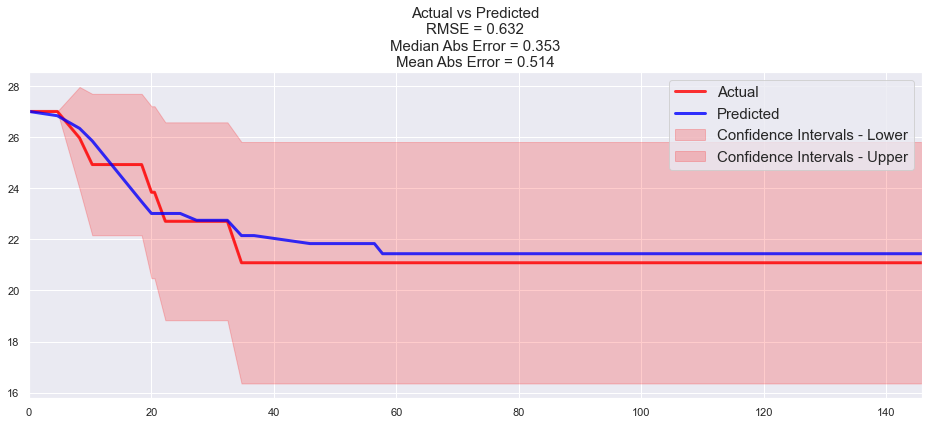

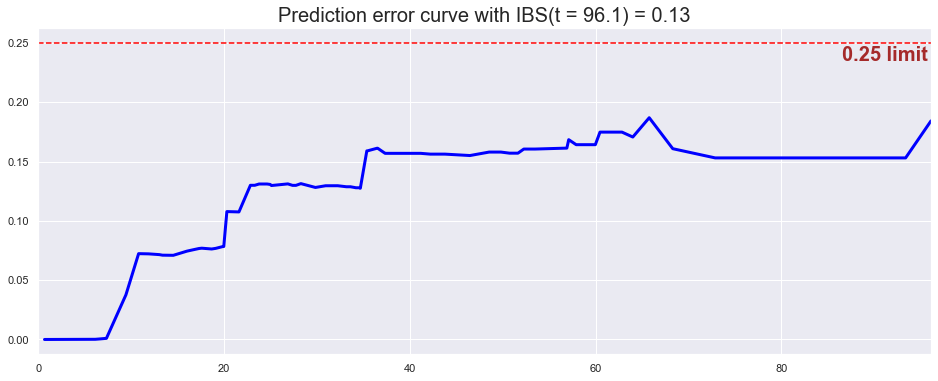

C-index: 0.72
IBS: 0.13

 2 of kfold 5


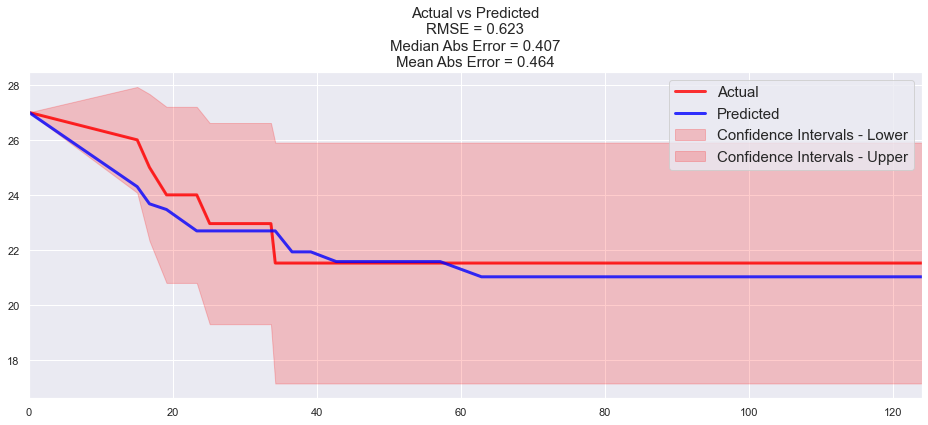

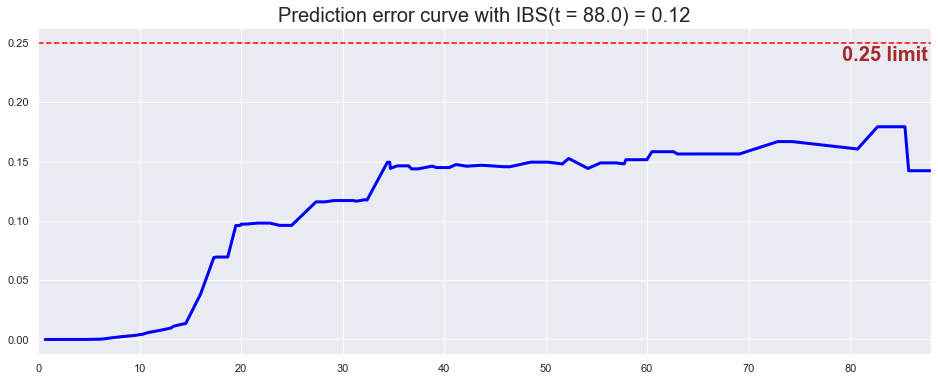

C-index: 0.78
IBS: 0.12

 3 of kfold 5


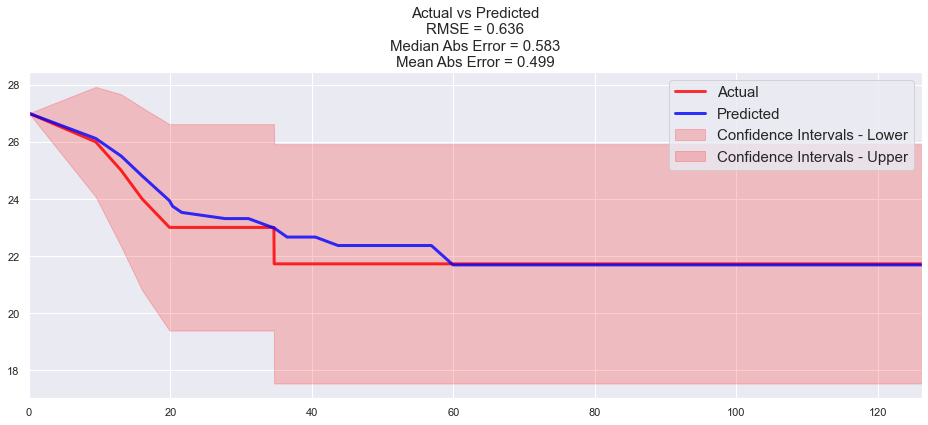

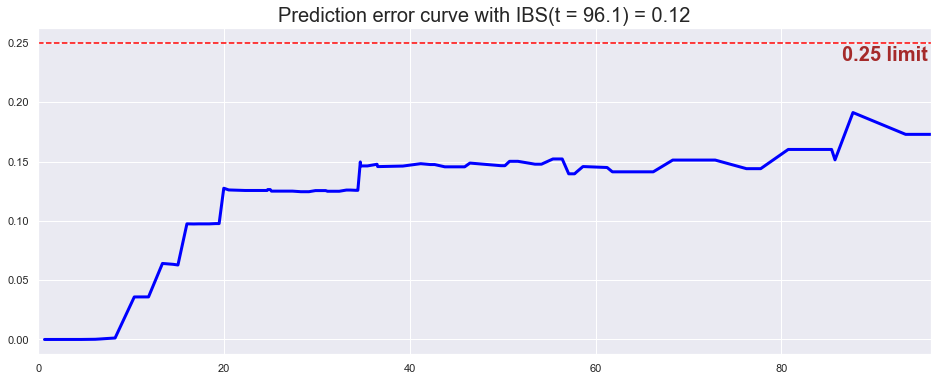

C-index: 0.68
IBS: 0.12

 4 of kfold 5


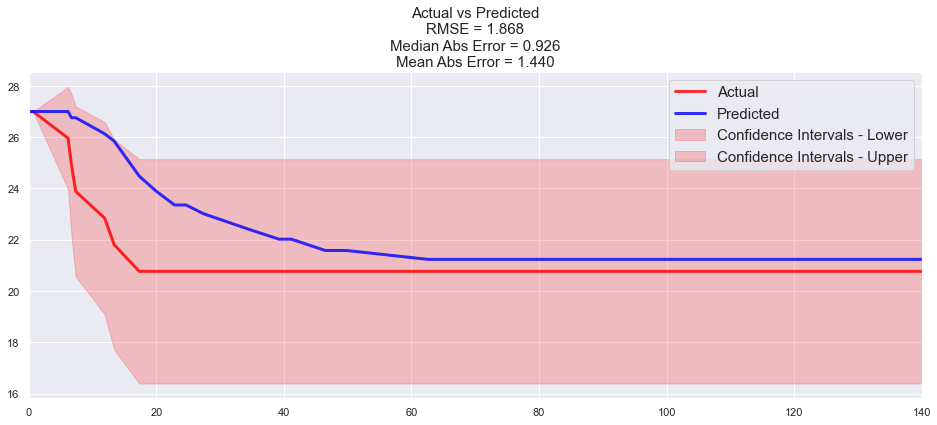

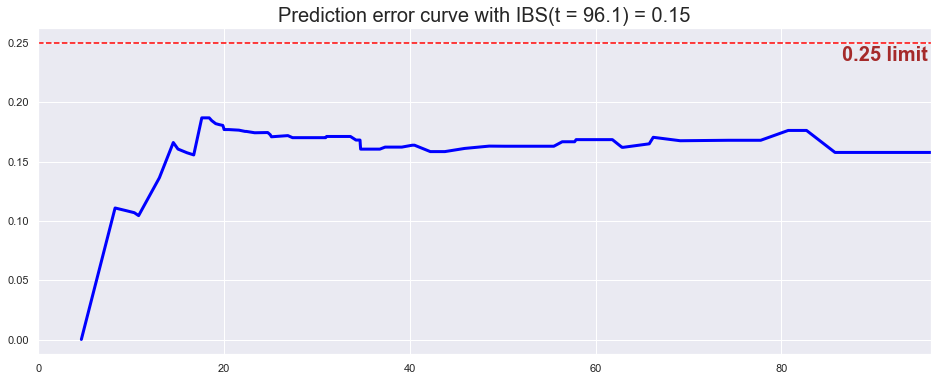

C-index: 0.74
IBS: 0.15

 5 of kfold 5


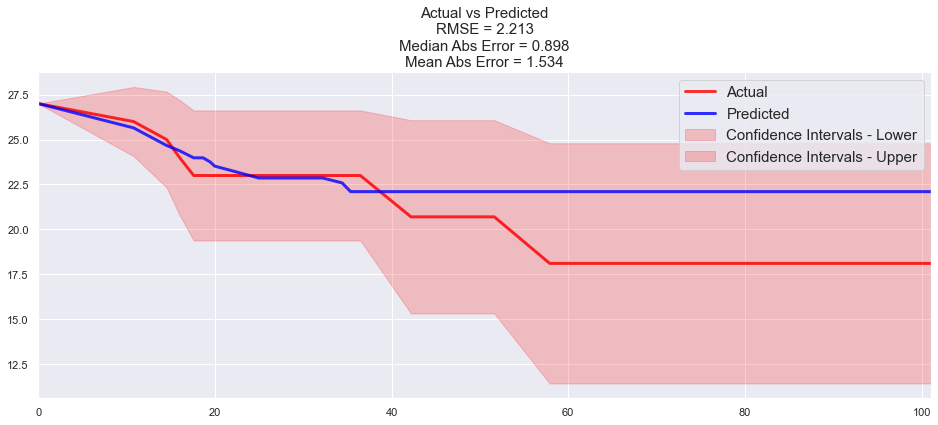

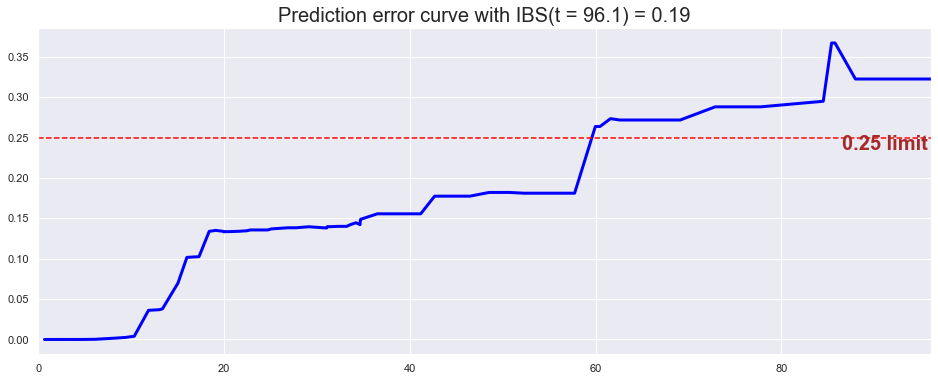

C-index: 0.51
IBS: 0.19
0.6876027935593362 0.10505605402923221 0.1417735357785453 0.02821976720744347


In [325]:
data2 = pd.read_csv('filtered_preop_and_radiomics.csv')
max_depth_best = 10
min_node_best = 5
num_tree_best = 400

# retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
# Creating the X, T and E inputs

time_column='time column'
event_column='event column'

features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
X = data2[features]
newX=np.setdiff1d(data2.columns, [event_column]).tolist()

X=data2[newX]
E=data2['event column']

CI = []
IBS = []

k_folds = 5
i=1
kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)


for train_index, test_index in kf.split(X,E):

    # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
    # gridsearch_data = pd.concat([X,E], axis=1)
    # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")

    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    X_train, X_test=X1_train[features], X1_test[features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst = RandomSurvivalForestModel(num_trees=num_tree_best) 

    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
        min_node_size = min_node_best, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )

    c_index = concordance_index(xst, X_test, T_test, E_test)
    results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
    CI.append(c_index)
    IBS.append(ibs)
    print('C-index: {:.2f}'.format(c_index))
    print('IBS: {:.2f}'.format(ibs))           
    i=i+1

CIAvg = mean(CI)
CIStd = statistics.stdev(CI)
IBSAvg = mean(IBS)
IBSStd = statistics.stdev(IBS)

print(CIAvg, CIStd, IBSAvg, IBSStd)

In [344]:


var_imp_dict = {}
var_list = var_imps['feature'].to_list()

imps = {key:[] for key in var_list}
pcts = {key:[] for key in var_list}
for var_name in var_list:
    imps[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['importance'].iloc[0])
    pcts[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['pct_importance'].iloc[0])

for var_name in var_list:
    imps[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['importance'].iloc[0])
    pcts[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['pct_importance'].iloc[0])

#average importances

var_imps_list = []
for var_name in var_list:
    imp_avg = mean(imps[var_name])
    imp_std = statistics.stdev(imps[var_name])
    pct_avg = mean(pcts[var_name])
    pct_std = statistics.stdev(pcts[var_name])

    var_imps_list.append([var_name, imp_avg, imp_std, pct_avg, pct_std])

var_imps_df = pd.DataFrame(var_imps_list, columns = ['Variable', 'Imp Avg','Imp Std', 'Pct Avg', 'Pct Std'])
